# Packages & housekeeping

In [1]:
import pandas as pd
from pandas import json_normalize 
import datetime
import requests
from datetime import datetime
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

Changing default plot Font Size

In [2]:
plt.rcParams.update({'font.size': 14})

Description of the API is to be found here:
https://www.vegvesen.no/trafikkdata/api/
and here:
https://www.vegvesen.no/trafikkdata/start/om-api

In [3]:
if not os.path.isdir('figures'):
    os.mkdir('figures')

# Request lists of municipalities and counties

In [4]:
counties_query = \
"""
{
  areas
  {
    counties
    {
      name
      number

    }
  }
}
"""
counties = requests.post('https://www.vegvesen.no/trafikkdata/api/', json={'query': counties_query}).json()['data']['areas']['counties']
counties = json_normalize(counties)
counties.sort_values(by = 'name', inplace = True)
# housekeeping
counties.reset_index(inplace = True)
counties.drop(columns = {'index'},inplace = True)
counties.set_index('number',inplace = True)
counties

name
number                 
42                Agder
32             Akershus
33             Buskerud
56             Finnmark
34            Innlandet
15      Møre og Romsdal
18             Nordland
3                  Oslo
11             Rogaland
40             Telemark
55                Troms
50            Trøndelag
39             Vestfold
46             Vestland
31              Østfold

In [5]:
query_municipalities = \
"""{
  areas
  {
    municipalities
    {
      name
      number
      county
      {
        name
      }
    }
  }
}"""
municipalities = requests.post('https://www.vegvesen.no/trafikkdata/api/', json={'query': query_municipalities}).json()['data']['areas']['municipalities']
municipalities = json_normalize(municipalities)
municipalities.rename(columns = {'county.name': 'county'},inplace = True)
municipalities.set_index('county',inplace = True)
municipalities.head()

name  number
county                        
Oslo              Oslo     301
Østfold           Moss    3103
Østfold        Aremark    3124
Østfold  Indre Østfold    3118
Østfold      Sarpsborg    3105

In [6]:
municipalities.loc['Rogaland']

name  number
county                      
Rogaland   Randaberg    1127
Rogaland      Strand    1130
Rogaland        Lund    1112
Rogaland       Sauda    1135
Rogaland     Gjesdal    1122
Rogaland          Hå    1119
Rogaland  Vindafjord    1160
Rogaland       Klepp    1120
Rogaland        Time    1121
Rogaland  Hjelmeland    1133
Rogaland      Tysvær    1146
Rogaland     Sandnes    1108
Rogaland      Karmøy    1149
Rogaland   Eigersund    1101
Rogaland     Sokndal    1111
Rogaland        Bokn    1145
Rogaland   Haugesund    1106
Rogaland      Utsira    1151
Rogaland     Kvitsøy    1144
Rogaland        Sola    1124
Rogaland      Suldal    1134
Rogaland   Bjerkreim    1114
Rogaland   Stavanger    1103

# Request traffic registration points (TRP)
The piece of code below requests list of TRP (name, id, coordinates) with the following additional classifiers:
 - traffic registration type: VEHICLE or BICYCLE
 - county (fylke) 
 - municipality (kommune)
 - road: category (E - European route, F - County road, K - Municipal road, P - Private road, R - National road.) and reference

In [7]:
query_TRP = \
"""
{
  trafficRegistrationPoints(searchQuery: {
    roadCategoryIds: []
    countyNumbers: []
    isOperational: true # Filter by traffic registration points currently registering traffic
  }) 
  {
    id
    name
    trafficRegistrationType
    location {
      county
      {
        name
        number
      }
        municipality
      {
        name
        number
      }
      roadReference
      {
        shortForm
        roadCategory
        {
          id
          name
        }
      }
      coordinates {
        latLon {
          lat
          lon
        }
      }
    }
  }
}
"""

TRP = requests.post('https://www.vegvesen.no/trafikkdata/api/', json={'query': query_TRP}).json()['data']['trafficRegistrationPoints']
TRP = json_normalize(TRP)
TRP.drop(columns = ['location.roadReference.roadCategory.name'],inplace = True)
TRP.rename(columns={'location.coordinates.latLon.lat': 'lat',
                    'location.coordinates.latLon.lon': 'lon',
                    'location.roadReference.roadCategory.id':'roadCategory',
                    'location.roadReference.shortForm':'road_ref',
                    'location.county.name':'county',
                    'location.county.number':'county_num',
                    'location.municipality.name':'municipality',
                    'location.municipality.number':'municipality_num',
                    'trafficRegistrationType':'trafficType'
                    }, inplace = True)
TRP = TRP[['id','name','trafficType','municipality','county','roadCategory','road_ref','lat','lon']]
TRP.set_index('id', inplace = True)
TRP.sample(5)

name trafficType municipality     county  \
id                                                                             
50284B2426199  Pirbrua sykkel - sørsiden     BICYCLE    Trondheim  Trøndelag   
85679V1060055                 ÅS BRU SØR     VEHICLE       Gjøvik  Innlandet   
69356V971439                     GLEMMEN     VEHICLE  Fredrikstad    Østfold   
00232V805106             Dalseid Fv. 569     VEHICLE      Vaksdal   Vestland   
04512V930297                     Vedbotn     VEHICLE     Nordkapp   Finnmark   

              roadCategory           road_ref        lat        lon  
id                                                                   
50284B2426199            R  RV706 S1D155 m355  63.438010  10.408223  
85679V1060055            F  FV2368 S2D1 m3669  60.783707  10.639859  
69356V971439             F   FV109 S1D1 m1954  59.229610  10.958013  
00232V805106             F     FV569 S1D1 m26  60.612463   5.832899  
04512V930297             E   EV69 S6D1 m13592  70.776832  25.631609

Saving Traffic Registration Points to a csv (can be visualized by by Kepler.gl):

In [8]:
TRP.to_csv('TRP.csv')

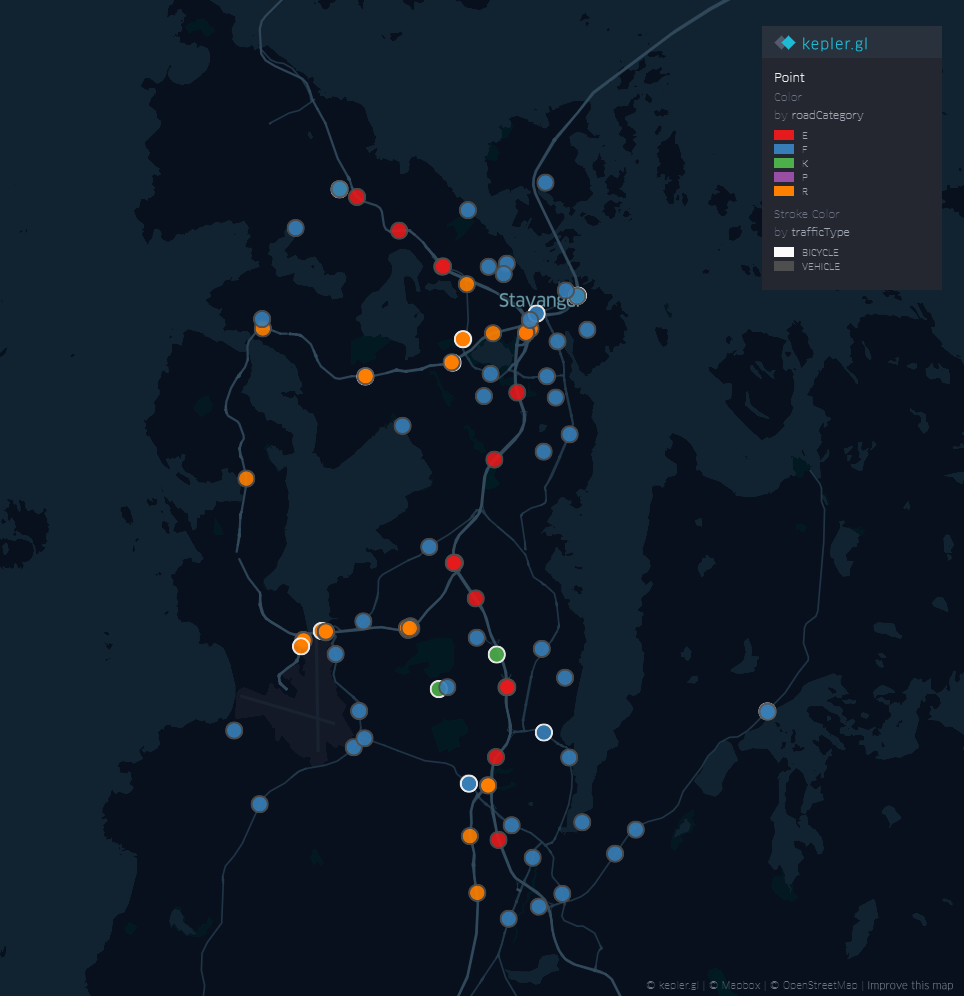

Examples of the different selections:

In [9]:
TRP.loc[(TRP.trafficType == 'VEHICLE') & ((TRP.municipality == 'Sola') | (TRP.municipality == 'Sandnes'))].head()

name trafficType municipality    county  \
id                                                                      
83652V319725       Strandgata nord     VEHICLE      Sandnes  Rogaland   
13606V2303025  Eikeberget SØ rampe     VEHICLE         Sola  Rogaland   
64040V320581       E39 / Somaveien     VEHICLE      Sandnes  Rogaland   
04873V320700               Bærheim     VEHICLE      Sandnes  Rogaland   
48362V320684        Solastrand sør     VEHICLE         Sola  Rogaland   

              roadCategory                  road_ref        lat       lon  
id                                                                         
83652V319725             F          FV44 S16D1 m2540  58.868273  5.744430  
13606V2303025            R  RV509 S1D1 m1799 KD4 m41  58.896513  5.677580  
64040V320581             E         EV39 S101D1 m2650  58.868374  5.713417  
04873V320700             F         FV4526 S3D1 m1224  58.883660  5.692813  
48362V320684             F         FV4524 S1D1 m2158  58.874188  5.602521

In [10]:
TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Sola','Sandnes'])]

name trafficType  \
id                                                                            
83652V319725                                    Strandgata nord     VEHICLE   
13606V2303025                               Eikeberget SØ rampe     VEHICLE   
64040V320581                                    E39 / Somaveien     VEHICLE   
04873V320700                                            Bærheim     VEHICLE   
48362V320684                                     Solastrand sør     VEHICLE   
74250V319516                                           Bråstein     VEHICLE   
81631V1727485                                   Asheimveien bru     VEHICLE   
61487V319872                                           Risavika     VEHICLE   
24330V320678                                   Forus Gamleveien     VEHICLE   
40696V1727469                                      Folkvord bru     VEHICLE   
41451V320581                                           Folkvord     VEHICLE   
88125V320152                                           Austrått     VEHICLE   
63432V319869                              Sola n. ved Arabergv.     VEHICLE   
44083V319868                                               Soma     VEHICLE   
55439V320125                                          Tengesdal     VEHICLE   
71787V2269011                                    Hana ved Rovik     VEHICLE   
00462V320124                                       Vatnekrossen     VEHICLE   
88184V2303031                               Eikeberget SV rampe     VEHICLE   
16074V319868                                           Oalsgata     VEHICLE   
09105V320634                                               Rege     VEHICLE   
45995V320592                                            Hogstad     VEHICLE   
73355V319671                                    Austråttunnelen     VEHICLE   
97275V319853                                        Ganddal sør     VEHICLE   
20586V2721334                  Flyplassvegen Sola PÅKJ mot sola     VEHICLE   
50741V1727509                         Smeaheia vest retning sør     VEHICLE   
91556V2721320              Flyplassvegen Sola AVKJ fra Sundekr.     VEHICLE   
33926V2721315                                Flyplassvegen Sola     VEHICLE   
99781V2303021                                        Eikeberget     VEHICLE   
89457V2303027                               Eikeberget NØ rampe     VEHICLE   
15931V2303033                               Eikeberget NV rampe     VEHICLE   
13433V319582         FORUS ved stv.Aftenbladet Avkj fra Sandnes     VEHICLE   
71798V319583          Forus ved Stv.Aftenblad påkj. mot Sandnes     VEHICLE   
84064V320581                            FORUS ved Stv.Aftenblad     VEHICLE   
58400V2721295               Sømmevågen PÅKJ fra Sola rampe nord     VEHICLE   
13715V2721330                                        Sømmevågen     VEHICLE   
06011V2726196                          Rampe fra Fv516 til E39      VEHICLE   
89467V3104336                                         Hove vest     VEHICLE   
38906V2726215  Rampe påkjøring fra Hove Fv516 til E39 sørgående     VEHICLE   
95626V320634                                    Stangeland nord     VEHICLE   
94180V2726102                        Rampe fra E39 mot Austrått     VEHICLE   
65096V2726170                  Rampe fra FV516 Austrått til E39     VEHICLE   
13000V2783697                                        Hove Fv516     VEHICLE   
10569V2580836                                        Stangeland     VEHICLE   
74012V320634                                     Stangeland sør     VEHICLE   
59675V319722                                           Brualand     VEHICLE   
21556V319919                                          Joabakken     VEHICLE   
89794V320138                                          Hoveveien     VEHICLE   
43296V319721                                           Åsedalen     VEHICLE   
35382V1727514                        Smeaheia Vest retning Nord     VEHICLE   
05268V320136                  

# Getting prepared to read traffic data

Public holidays in Norway
https://www.timeanddate.no/merkedag/norge/2019?hol=1

In [11]:
id = '68351V319882' # Kannik
id = '66678V320582' # AUGLEND
id = '26738V320582' # E39 Forus nord
id = '71798V319583' # Forus ved Stv.Aftenblad påkj. mot Sandnes
id = '84064V320581' # FORUS ved Stv.Aftenblad

Today's time and date:

In [12]:
time_now_str = str(datetime.utcnow().date()) + 'T00:00:00+02:00'
time_now_str

'2024-04-23T00:00:00+02:00'

## Query templates

### Template for Average daily traffic volume per year
#id - id of a TRP
Note: "Coverage is a measure for how much of a time period there is valid data for. For traffic volume per hour or day, coverage is the ratio of time with valid data to the whole time period. For average daily traffic volume, coverage is the average coverage for days with sufficient coverage (>95%), multiplied by the ratio of number of days with sufficient coverage (>95%) to the total number of days in the period."

In [13]:
query_YADTV_temp = """
{
  trafficData(trafficRegistrationPointId: "#id") {
    volume {
      average {
        daily {
          byYear {
            year
            total {
              volume {
                average
                confidenceInterval {
                  lowerBound
                  upperBound
                }
              }
              coverage {
                percentage
              }
            }
          }
        }
      }
    }
  }
}
"""

### Template for hourly traffic volume

In [14]:
query_HTV_temp = """{
  trafficData(trafficRegistrationPointId: "#id") {
    volume {
      byHour(from: "#t1", to: "#t2") {
        edges {
          node {
            from
            to
            total {
              volumeNumbers {
                volume
              }
              coverage {
                percentage
              }
            }
          }
        }
      }
    }
  }
}"""

### Template for daily traffic volume

In [15]:
query_DTV_temp = """{
  trafficData(trafficRegistrationPointId: "#id") {
    volume {
      byDay(from: "#t1", to: "#t2") {
        edges {
          node {
            from
            to
            total {
              volumeNumbers {
                volume
              }
              coverage {
                percentage
              }
            }
          }
        }
      }
    }
  }
}"""

Example for id ='40190V319527' #SOKN - TRP on E39, to the north of Stavanger

In [16]:
import requests
import pandas as pd
from pandas import json_normalize 

query_example = """{
  trafficData(trafficRegistrationPointId: "40190V319527") {
    volume {
      byDay(from: "2019-01-01T00:00:00+02:00", to: "2020-07-23T00:00:00+02:00") {
        edges {
          node {
            from
            to
            total {
              volumeNumbers {
                volume
              }
              coverage {
                percentage
              }}}}}}}}"""

DTV = requests.post('https://www.vegvesen.no/trafikkdata/api/', json={'query': query_example}).json()
DTV = DTV['data']['trafficData']['volume']['byDay']['edges']
DTV = json_normalize(DTV)
DTV.head()

node.from                    node.to  \
0  2018-12-31T00:00:00+01:00  2019-01-01T00:00:00+01:00   
1  2019-01-01T00:00:00+01:00  2019-01-02T00:00:00+01:00   
2  2019-01-02T00:00:00+01:00  2019-01-03T00:00:00+01:00   
3  2019-01-03T00:00:00+01:00  2019-01-04T00:00:00+01:00   
4  2019-01-04T00:00:00+01:00  2019-01-05T00:00:00+01:00   

   node.total.volumeNumbers.volume  node.total.coverage.percentage  
0                             5249                           100.0  
1                             5720                           100.0  
2                             9124                           100.0  
3                             8574                           100.0  
4                             9197                           100.0

## Functions to request and process traffic data

Function to build a query from a template (QT) for the specified TRP id (id) and time interval (t1 and t2):

In [17]:
def create_query(QT, 
                 id = '44656V72812', 
                 t1 = '2019-01-01T00:00:00+02:00', 
                 t2 = time_now_str):
    Q = QT.replace('#id',id)
    Q = Q.replace('#t1',t1)
    Q = Q.replace('#t2',t2)
    return Q

### Request function
1. requests Yearly Averaged Daily Traffic Volume (YADTV) for 2019
2. requests daily traffic data for one TRP
3. calculates the traffic index as: [2]/[1]
4. calculates 7-day moving average

In [18]:
def request_traffic_data(id = '44656V72812', disp = False, t1 = '2018-12-01T00:00:00+02:00',t2 = time_now_str):
    # reading yearly averaged daily traffic volume for TRP with id, from t1 to t2
    # disp
    query_YADTV = create_query(query_YADTV_temp,id)
    DTV = pd.DataFrame()
    YADTV = requests.post('https://www.vegvesen.no/trafikkdata/api/', json={'query': query_YADTV}).json()
    if disp:
        print(YADTV)
#     try:
    YADTV = YADTV['data']['trafficData']['volume']['average']['daily']['byYear']
    YADTV = json_normalize(YADTV)
    YADTV.rename(columns={'total.coverage.percentage': 'coverage','total.volume.average':'volume',
                      'total.volume.confidenceInterval.lowerBound': 'volume_LB',
                      'total.volume.confidenceInterval.upperBound': 'volume_UB'}, inplace = True)
    YADTV = YADTV[YADTV.columns[::-1]]
    YADTV.set_index('year', inplace = True)
    # reading daily traffic volume
    t1_num = datetime.fromisoformat(t1).toordinal()
    t2_num = datetime.fromisoformat(t2).toordinal()
    while t1_num < t2_num:
        query_DTV = create_query(query_DTV_temp, id, t1, t2)
        #print(' from ' + t1 + ' to ' + t2)
        DTV_temp = requests.post('https://www.vegvesen.no/trafikkdata/api/', json={'query': query_DTV}).json()
        DTV_temp = DTV_temp['data']['trafficData']['volume']['byDay']['edges']
        DTV_temp = json_normalize(DTV_temp)

        if DTV_temp.empty:
            break

#         DTV_temp['date0'] = DTV_temp['node.to']
        DTV_temp['date'] = pd.to_datetime(DTV_temp['node.to'],utc=True).dt.date
        t1 = DTV_temp['node.to'].iloc[-1]       
        t1_num = datetime.fromisoformat(t1).toordinal()  
        DTV_temp.drop(columns = {'node.to','node.from'},inplace=True)
        try:
            DTV_temp.rename(columns={'node.total.volumeNumbers.volume': 'volume',
                                    'node.total.coverage.percentage':'coverage'},inplace = True)                  
#             print(DTV_temp.head(1))   
            
            if 'volume' not in  DTV_temp.columns:
                DTV_temp['volume'] = None

            DTV_temp = DTV_temp[['date','volume','coverage',]]
            DTV = pd.concat([DTV, DTV_temp],sort=False)
            if disp:
                print('--------------------------------------')    
                print(DTV_temp.iloc[[0, -1]])
#                 print(DTV_temp.tail(1))             
        except:
            if disp:
                print('-------error--------------------------')  
            continue  
    
    DTV['traffic_index'] = DTV['volume']/YADTV['volume'][2019]
    # Adding a column with 7-day moving average
    DTV['traffic_index_MA7'] = DTV['traffic_index'].rolling(window = 7).mean()
    DTV['YADTV'] = YADTV['volume'][2019]
    DTV.set_index('date', inplace = True)          
    return DTV

### Looped requests
    - request the data for many TRPs in loop
    - save the results as a dictionary of Pandas dataframes TDD (TDD - traffic data dictionary) :

In [19]:
def request_traffic_data_loop(IDs, case_name = None):
    if not os.path.exists('TDD_' + case_name + '.pkl'):
        t1 = datetime.now()
        L = len(IDs)
        if case_name == None:
            case_name =  str(L) + '_IDs'
        
        save2 = 'TDD_' + case_name + '.pkl'
        log_file = save2.replace('.pkl','.log')
        
        lf = open(log_file,'w')
        print(len(IDs),' TRP(s) to read')
        
        c = 0
        TDD = dict()
        for i,id in enumerate(IDs):
            log_str = str(i)+'. '+ id +', '+ str(TRP.loc[id,'roadCategory'])+', ' + \
            TRP.loc[id,'county']+', '+TRP.loc[id,'municipality']+', '+TRP.loc[id,'name']
            try:
                TDD[id] =  request_traffic_data(id)
                log_str = log_str + ' - ok'
                c = c + 1
            except:
                log_str = log_str + ' - some error!'
                continue
                
            print(log_str)
            
            lf.write(log_str + '\n')  
#         with open(log_file,'a') as lf:
#             lf.write(log_str + '\n')    

            if (i + 1) % 25 == 0:
                clear_output()
        # saving
        lf.close()
        t2 = datetime.now()
        print(c,'( out of ',L,') TRPs successfully polled')
        print('Elapsed time:',(t2 - t1).total_seconds(),' s')

        outfile = open(save2,'wb')
        pickle.dump(TDD,outfile)
        outfile.close()

        print('TDD is saved in ' + save2)
    else:
        # loading from the file
        print('reading TDD_' + case_name + '.pkl' )
        ff = open('TDD_' + case_name + '.pkl','rb')
        TDD = pickle.load(ff)
        ff.close()
    return TDD

### plot Traffic Index (TI)

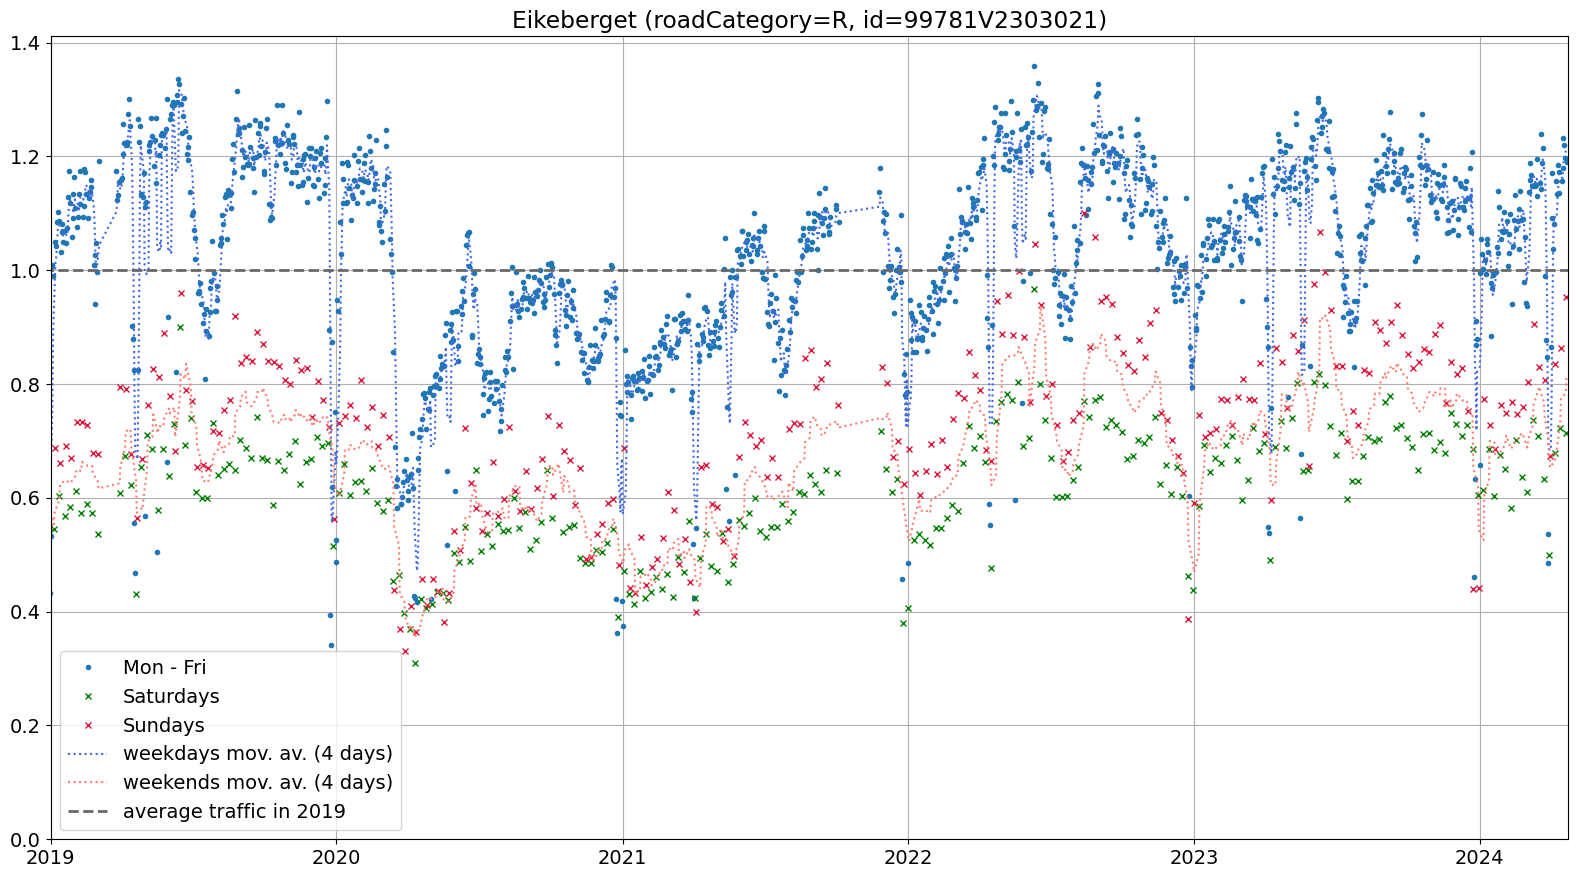

In [20]:
def plot_TI(DTV,id = None, **kwargs):
    # defaults
    
    # to save or not to save: boolean
    save_switch = kwargs.get('save')       
    
    # from date (yyyy.mm.dd)
    from_date = kwargs.get('from_date')
    if from_date == None:
        from_date = '2019-01-01'
    
    fridays = kwargs.get('fridays')
    if fridays == None:
        fridays == False
        
    
    # to date (yyyy.mm.dd)
    to_date   = kwargs.get('to_date')
    if to_date == None:
        to_date = time_now_str

    # title
    ttl   = kwargs.get('title')
    
    # moving averages (like: MA = 5, where 5 is the window size)
    MA   = kwargs.get('MA')

    ylim  = kwargs.get('ylim')

    plt.figure(figsize=(16,9)) # PPT presentation
    
    
    if type(DTV) == pd.core.series.Series:        
        y = DTV
    else:
        DTV.dropna(subset = ['traffic_index'], inplace = True)
        DTV = DTV.loc[DTV['coverage'] > 95,:] # dropping points with coverage less than 95%
        y = DTV['traffic_index']
    
    x = DTV.index
    
    mon_fri = pd.to_datetime(DTV.index).dayofweek.isin(range(5))
    sat = pd.to_datetime(DTV.index).dayofweek.isin([5])
    sun = pd.to_datetime(DTV.index).dayofweek.isin([6])
    sat_sun = pd.to_datetime(DTV.index).dayofweek.isin([5,6])
        
    if fridays == True:
        mon_thu = pd.to_datetime(DTV.index).dayofweek.isin(range(4))
        fri = pd.to_datetime(DTV.index).dayofweek.isin([4])
        plt.plot_date(x[mon_thu],y[mon_thu], markersize = 3,label = 'Mon - Thu')  
        plt.plot_date(x[fri],   y[fri], markersize = 5, color = '#1f77b4', label = 'Fridays')
        plt.plot_date(x[sat],   y[sat],'x', markersize = 5, color = 'green',label = 'Saturdays')
        plt.plot_date(x[sun],    y[sun], 'x', markersize = 5, color = 'crimson',label = 'Sundays')      
    else:
        plt.plot_date(x[mon_fri],y[mon_fri], markersize = 3,label = 'Mon - Fri')    
        plt.plot_date(x[sat],   y[sat],'x', markersize = 5, color = 'green',label = 'Saturdays')
        plt.plot_date(x[sun],    y[sun], 'x', markersize = 5, color = 'crimson',label = 'Sundays')    
        
        
    if MA != None:
        plt.plot_date(x[mon_fri],y[mon_fri].rolling(window = MA).mean(), ':', color = 'royalblue',label = 'weekdays mov. av. ('+  str(MA)+ ' days)') 
        plt.plot_date(x[sat_sun],y[sat_sun].rolling(window = MA).mean(), ':', color = 'salmon',   label = 'weekends mov. av. (' + str(MA)+ ' days)') 

    plt.plot_date(list(plt.xlim()),[1,1],'--',color = 'dimgrey',label = 'average traffic in 2019',linewidth = 2)
    
    from_date = datetime.fromisoformat(from_date).date()
    to_date = datetime.fromisoformat(to_date).date()
    
    plt.xlim(from_date,to_date)
    if ylim != None:
        plt.ylim(ylim)
    else:
        plt.ylim(ymin = 0)
        
    ylim = plt.ylim()
    
    if ttl == None:
        if id != None:
            ttl = TRP['name'][id] + ' (roadCategory=' + TRP['roadCategory'][id] + ', id='  + id + ')'
            plt.title(ttl) 
    else:     
        plt.title(ttl); # , fontsize = 16

    marks = kwargs.get('marks')
    if marks != None:
        for k in marks.keys():
            d = k.replace('-','.')
            d = datetime.strptime(d,'%Y.%m.%d')
            if marks[k].get('ls') == None:
                marks[k]['ls'] = np.random.choice(['--','-.',':'])
            if marks[k].get('c') == None:
                marks[k]['c'] = np.random.choice(['dimgrey','maroon','navy','forestgreen'])
            plt.plot_date([d,  d], ylim, color = marks[k]['c'], linestyle = marks[k]['ls'], label = marks[k].get('label'), marker = None)
        
    plt.legend()
    plt.grid()
    plt.tight_layout()
    
    if save_switch == True:
        plt.savefig('.\\figures\\' + ttl + '.png',dpi=300)

    plt.show()
        
id = '99781V2303021' #'Eikeberget'
DTV = request_traffic_data(id)
plot_TI(DTV, id, from_date = '2019-01-01', to_date = time_now_str, MA = 4, save = True)    

### TDD processing
- converts TDD into single DataFrame
- drops NaN and points with coverage less than 90%

In [21]:
# def process_TDD(X, **kwargs):
def process_TDD(X, IDs = None):
    
    # checking if IDs is iterable
    try:
        for i in IDs:
            pass
    except:
        IDs = X.keys()

#     print(IDs)
    Y = pd.DataFrame()
    
    for i in IDs:
        try:
            X[i]['id'] = i
            Y = pd.concat([Y,X[i]])
        except:
            continue
        
#     Y['id'].astype('category', inplace = True)
    Y = Y.loc[Y['coverage'] > 90,:]
    Y.dropna(subset = ['traffic_index'],inplace = True) 
    return Y

# # GSV = process_TDD(GSV, IDs)
# TRP_Randaberg = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Randaberg'])]
# # TRP_Randaberg
# R = request_traffic_data_loop(TRP_Randaberg.index,'Randaberg')   
# RR = process_TDD(R,TRP_Randaberg.index)
# RR.head()

### Weighted average function

In [22]:
def wavg(df, avg_col_name, weight_col_name):
    x = df[avg_col_name]
    w = df[weight_col_name]
    try:
        return (x * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

## Some demos

### Requesting and plotting traffic data 

C:\Users\alkh\AppData\Local\Temp\ipykernel_23240\2554925559.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date([d,  d], ylim, color = marks[k]['c'], linestyle = marks[k]['ls'], label = marks[k].get('label'), marker = None)


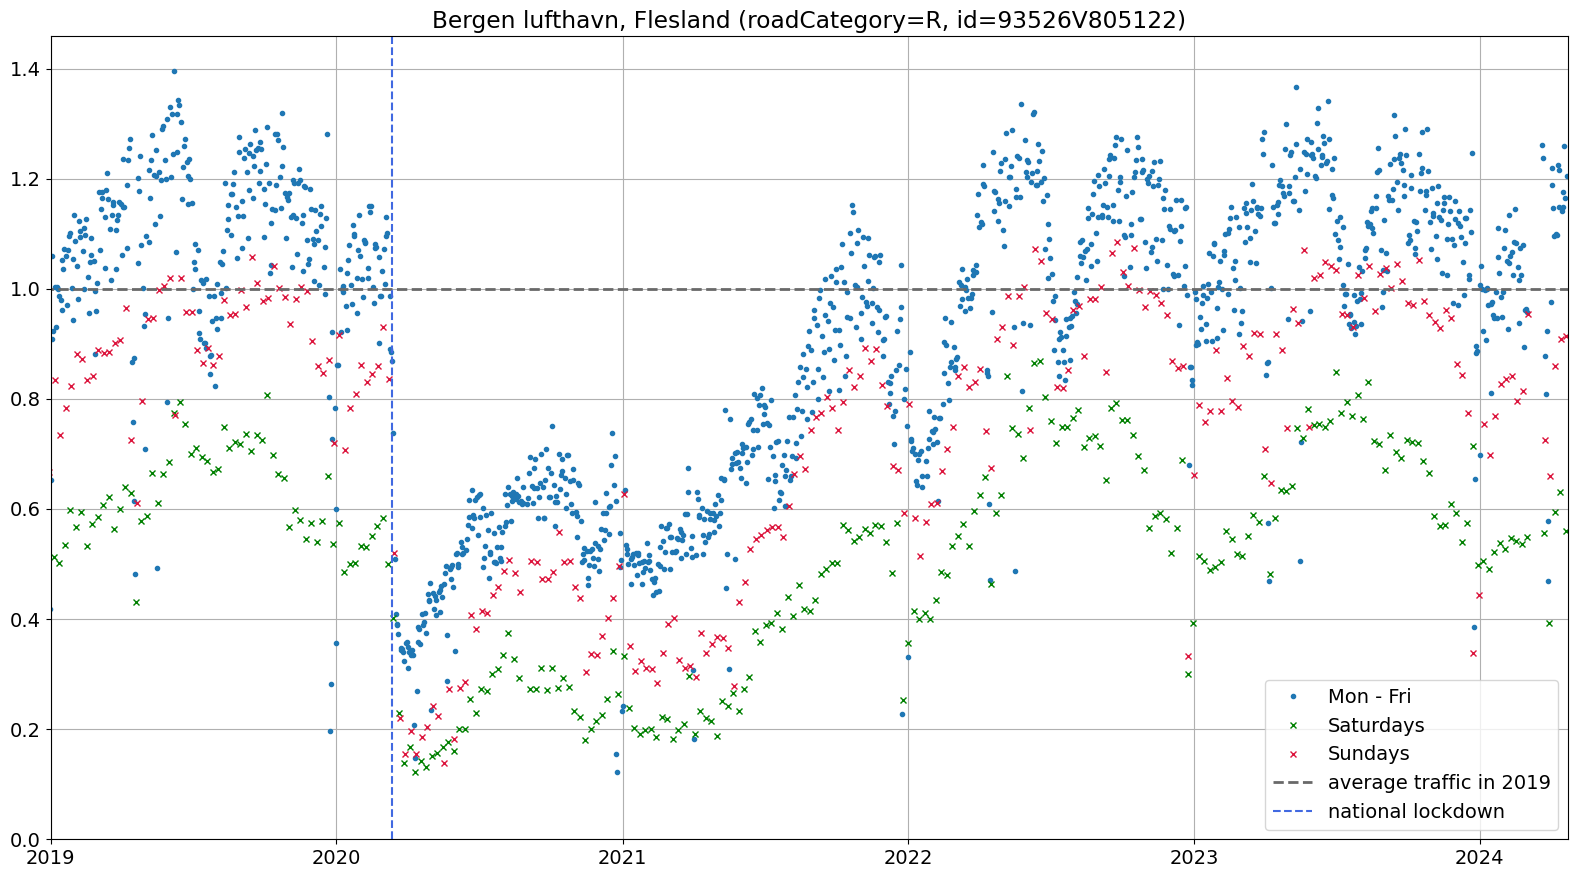

In [23]:
# id = '68351V319882' # Kannik
# id = '66678V320582' # AUGLEND
# id = '99781V2303021' #'Eikeberget'
# id='68684V319527' # Askje
# id ='40190V319527' #SOKN - TRP on E39, to the north of Stavanger
# id = '35382V1727514' # Smeaheia Vest retning Nord
# id = '13715V2721330' # name Sømmevågen - enterance to the Sola airport
# id = '26738V320582' # E39 Forus nord
id = '93526V805122' # BG.LUFTHAVN,FLESLAND
# id = '61487V319872' # Risavika

# M = {'national lockdown': {'date': '2020.03.12','color': 'red','linestyle': '--'}, 'HB':{'date': '2020.03.30'}}
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}, 
#      '2020.04.27':{'label':'schools reopen'},
#      '2019.06.20':{'label':'Sommerruter','ls': '--','c': 'grey'},
#      '2019.08.16':{'label':'Sommerruter','ls': '--','c': 'grey'},
    }

DTV = request_traffic_data(id)
plot_TI(DTV, id, from_date = '2019-01-01', to_date = time_now_str, marks = M)

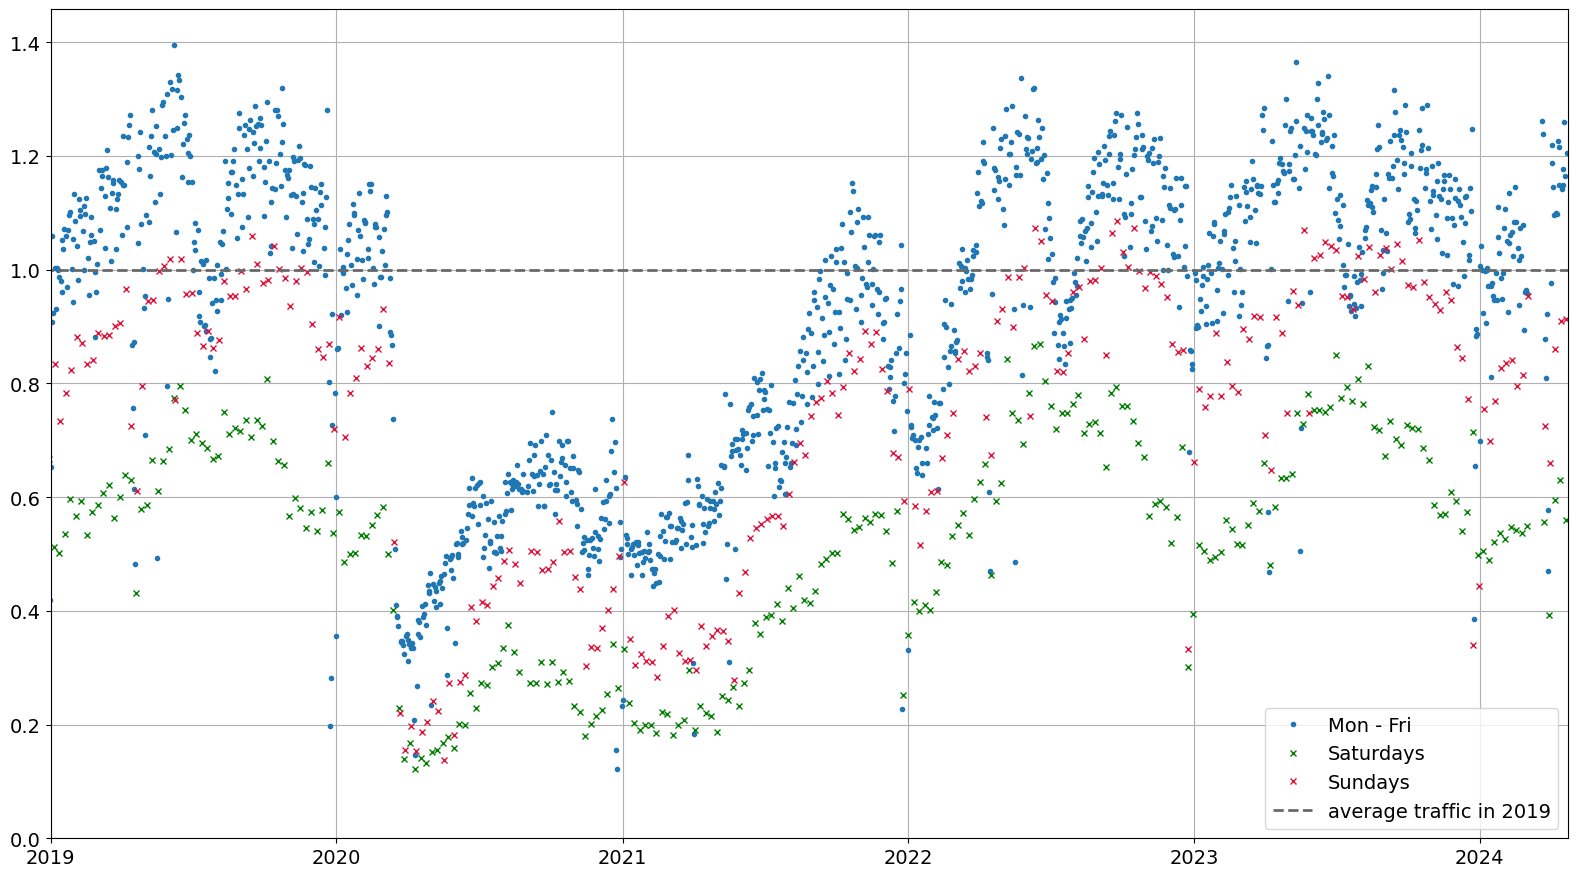

In [24]:
plot_TI(DTV)

In [25]:
DTV.head()

volume  coverage  traffic_index  traffic_index_MA7  YADTV
date                                                                  
2018-11-30  16563.0     100.0       1.179365                NaN  14044
2018-12-01   8523.0     100.0       0.606878                NaN  14044
2018-12-02  12757.0     100.0       0.908359                NaN  14044
2018-12-03  15025.0     100.0       1.069852                NaN  14044
2018-12-04  14042.0     100.0       0.999858                NaN  14044

In [26]:
DTV.tail()

volume  coverage  traffic_index  traffic_index_MA7  YADTV
date                                                                  
2024-04-18  17682.0     100.0       1.259043           1.059314  14044
2024-04-19  16350.0     100.0       1.164198           1.061440  14044
2024-04-20   7862.0     100.0       0.559812           1.051339  14044
2024-04-21  12834.0     100.0       0.913842           1.051949  14044
2024-04-22  16917.0     100.0       1.204571           1.060961  14044

### Randaberg

Requesting vehicle data from all TRPs in Randaberg:

In [27]:
TRP_Randaberg = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Randaberg'])]
TRP_Randaberg

name trafficType municipality    county roadCategory  \
id                                                                              
52780V320689           Håland     VEHICLE    Randaberg  Rogaland            F   
05658V320707  Randabergsletta     VEHICLE    Randaberg  Rogaland            F   

                       road_ref        lat       lon  
id                                                    
52780V320689  FV4560 S2D1 m1390  58.984062  5.628547  
05658V320707   FV4590 S2D1 m123  58.992550  5.647208

Requesting traffic data for the selected TRP and saving them:

In [28]:
R = request_traffic_data_loop(TRP_Randaberg.index,'Randaberg') 
R['52780V320689'].iloc[[0,1,-2,-1],:]

reading TDD_Randaberg.pkl


volume  coverage  traffic_index  traffic_index_MA7  YADTV
date                                                                 
2018-12-01    4551     100.0       0.650236                NaN   6999
2018-12-02    4321     100.0       0.617374                NaN   6999
2020-07-27    6991     100.0       0.998857           0.898149   6999
2020-07-28    6720     100.0       0.960137           0.896700   6999

Merging data into single DataFrame:

In [29]:
RR = process_TDD(R)
RR.sample(5)

volume  coverage  traffic_index  traffic_index_MA7  YADTV  \
date                                                                    
2020-07-26    4977     100.0       0.711102           0.900639   6999   
2018-12-24    4162     100.0       0.594656           1.002164   6999   
2019-02-18    9515     100.0       1.115867           1.019635   8527   
2019-02-16    4312     100.0       0.616088           1.004715   6999   
2020-06-24   11071     100.0       1.298346           1.154652   8527   

                      id  
date                      
2020-07-26  52780V320689  
2018-12-24  52780V320689  
2019-02-18  05658V320707  
2019-02-16  52780V320689  
2020-06-24  05658V320707

# Polling all TRPs in Norway
NB!
Execution of the code block below takes ca. one hour!

After successful run, a file with name ('TDD_' + case_name + '.pkl') is created and will be uploaded during subsequent runs. 

Remove this file if you need to request data anew.

In [30]:
case_name = 'ALL' 
# os.remove('TDD_' + case_name + '.pkl') # uncomment this line to request the data anew
IDs = TRP.index
ALL = request_traffic_data_loop(IDs, case_name) 

reading TDD_ALL.pkl


# Analysis

## Oslo

C:\Users\alkh\AppData\Local\Temp\ipykernel_23240\2554925559.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date([d,  d], ylim, color = marks[k]['c'], linestyle = marks[k]['ls'], label = marks[k].get('label'), marker = None)


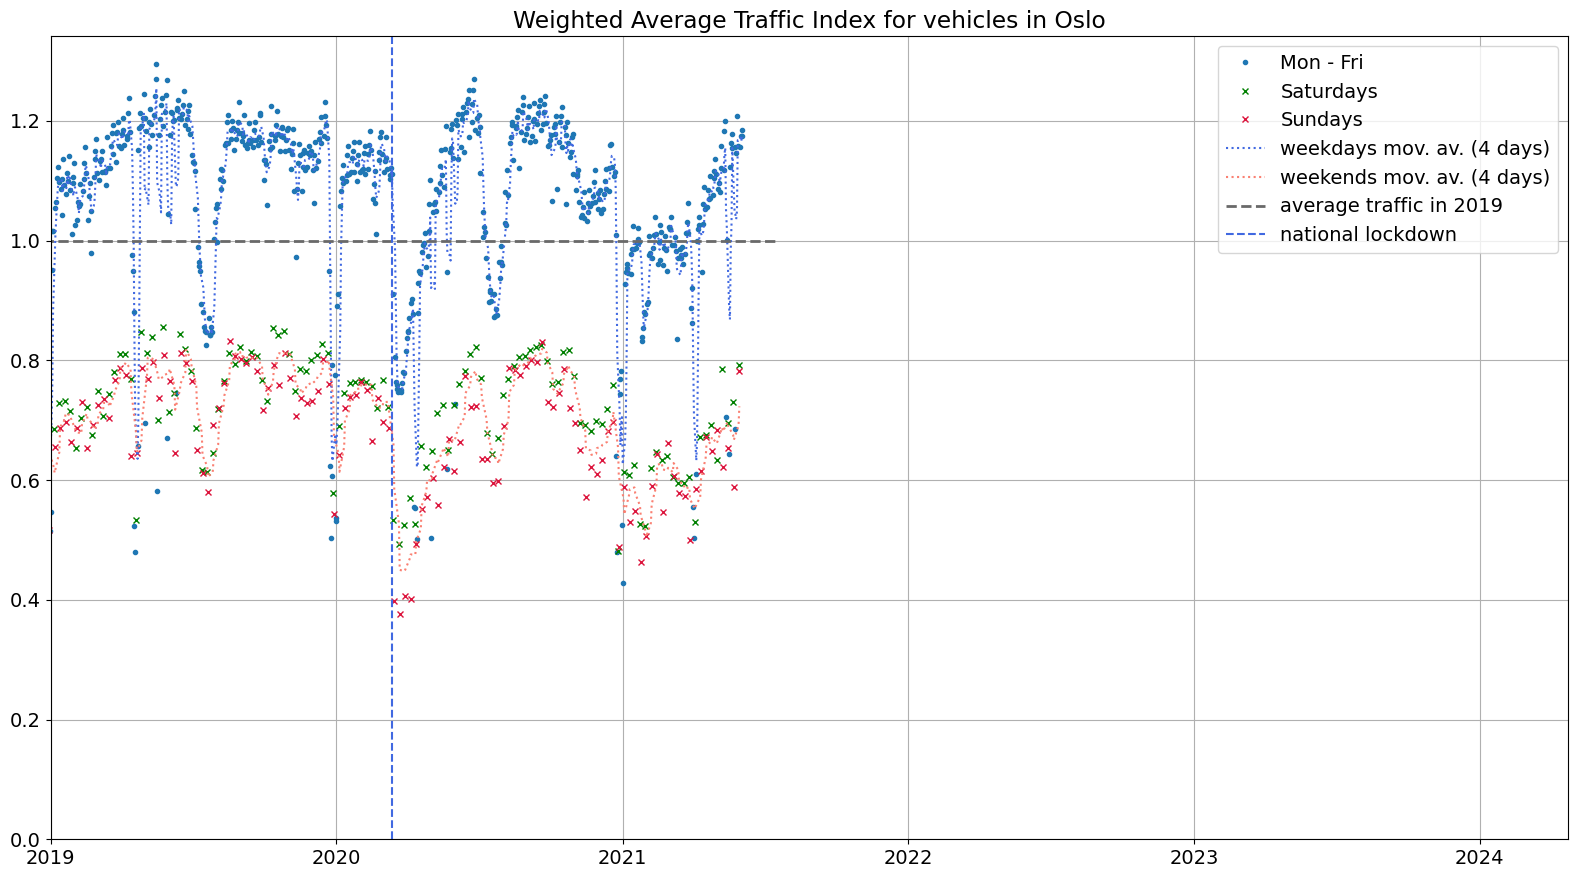

In [31]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Oslo'])].index
OSL = process_TDD(ALL,IDs)
OSL_wavg = OSL.groupby('date').apply(wavg,'traffic_index','YADTV')
OSL_d = OSL['traffic_index'].groupby('date').describe()

M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}, 
#      '2020.04.27':{'label':'schools reopen'},
    }
plot_TI(OSL_wavg,marks = M, title = 'Weighted Average Traffic Index for vehicles in Oslo', save = True, MA = 4)

In [32]:
ALL['52780V320689']

volume  coverage  traffic_index  traffic_index_MA7  YADTV
date                                                                 
2018-11-30    8038     100.0       1.148286                NaN   7000
2018-12-01    4551     100.0       0.650143                NaN   7000
2018-12-02    4321     100.0       0.617286                NaN   7000
2018-12-03    7857     100.0       1.122429                NaN   7000
2018-12-04    7905     100.0       1.129286                NaN   7000
...            ...       ...            ...                ...    ...
2021-05-30    5204     100.0       0.743429           0.968857   7000
2021-05-31    7853     100.0       1.121857           1.029776   7000
2021-06-01    8614     100.0       1.230571           1.043102   7000
2021-06-02    8122     100.0       1.160286           1.044980   7000
2021-06-03    8826     100.0       1.260857           1.051612   7000

[917 rows x 5 columns]

## Bergen

C:\Users\alkh\AppData\Local\Temp\ipykernel_23240\2554925559.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date([d,  d], ylim, color = marks[k]['c'], linestyle = marks[k]['ls'], label = marks[k].get('label'), marker = None)


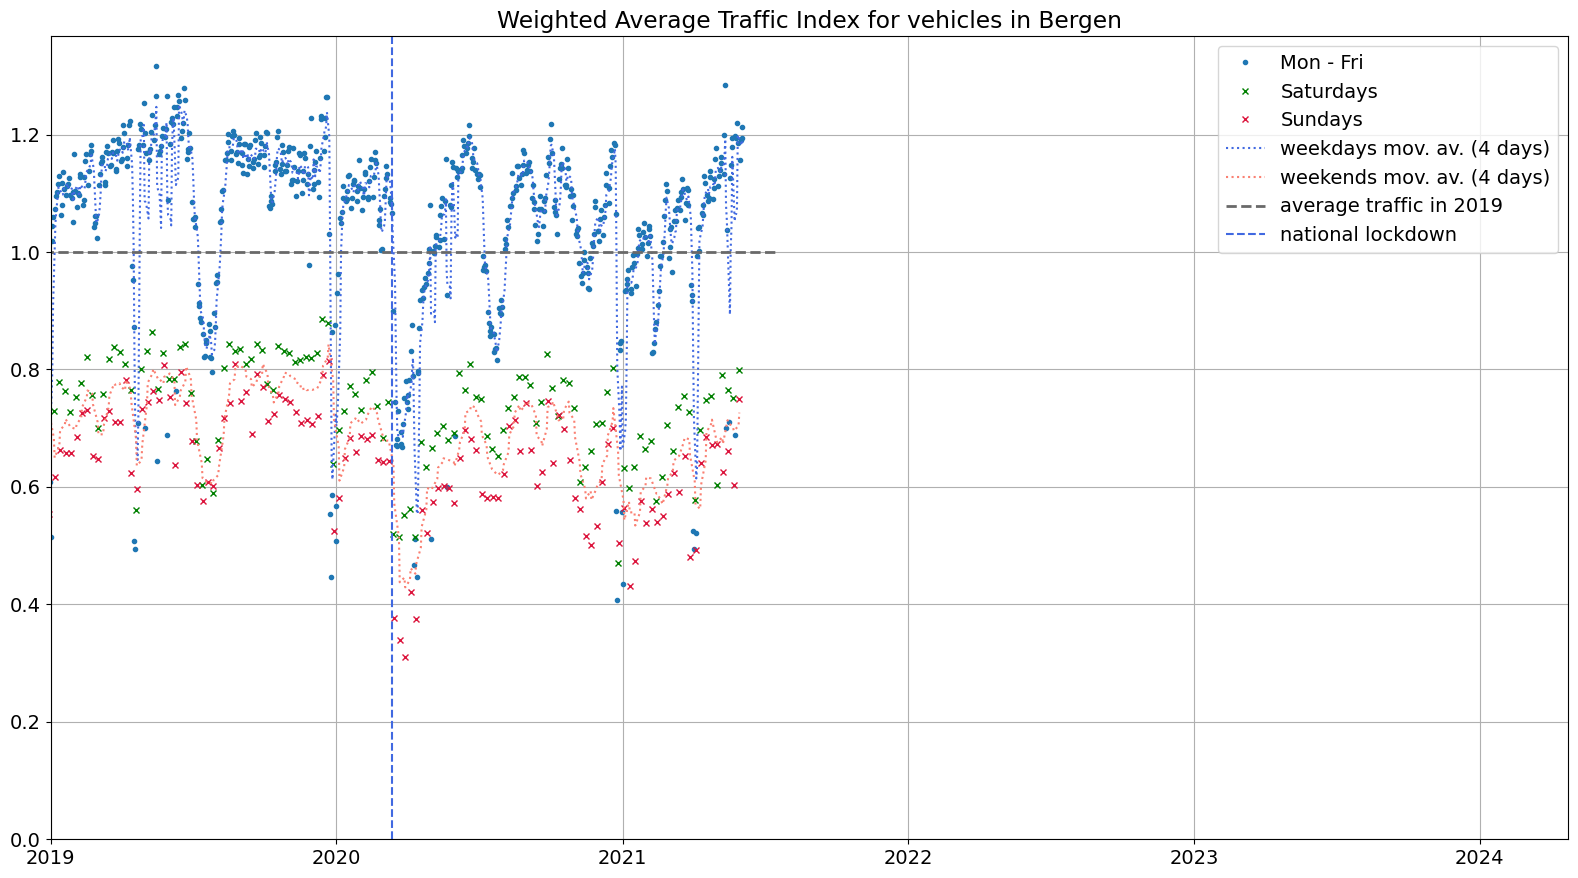

In [33]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Bergen'])].index
BRG = process_TDD(ALL,IDs)
BRG_wavg = BRG.groupby('date').apply(wavg,'traffic_index','YADTV')
BRG_d = BRG['traffic_index'].groupby('date').describe()

M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}, 
#      '2020.04.27':{'label':'schools reopen'},
    }
plot_TI(BRG_wavg,marks = M, title = 'Weighted Average Traffic Index for vehicles in Bergen', save = True, MA = 4)

## The Greater Stavanger Area

Stavanger, Sola, Sandness and Randaberg

### Vehicles

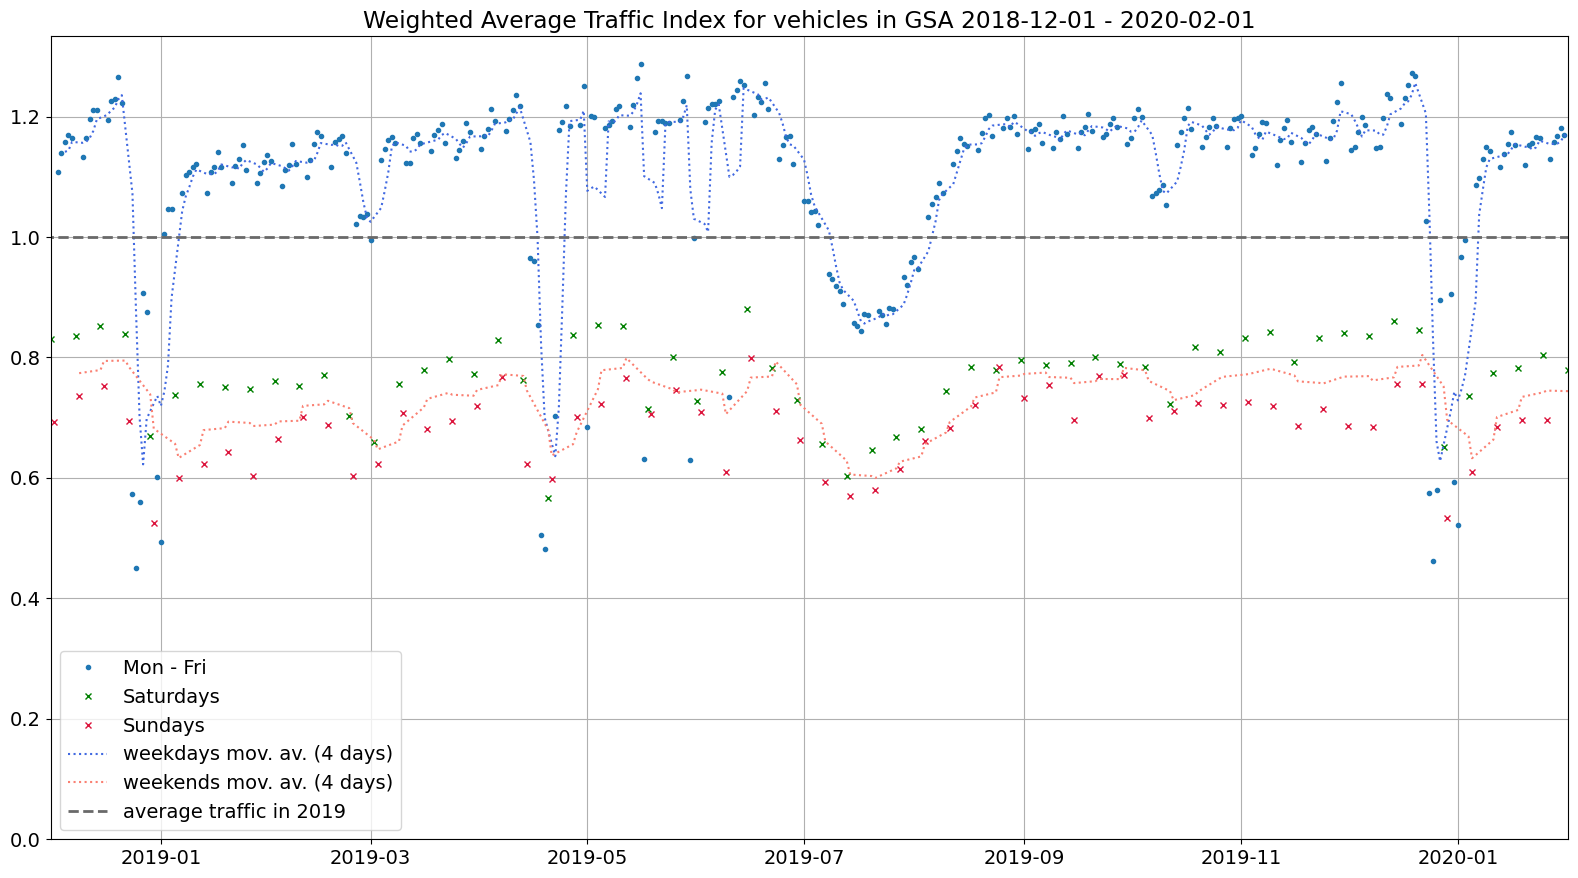

C:\Users\alkh\AppData\Local\Temp\ipykernel_23240\2554925559.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date([d,  d], ylim, color = marks[k]['c'], linestyle = marks[k]['ls'], label = marks[k].get('label'), marker = None)


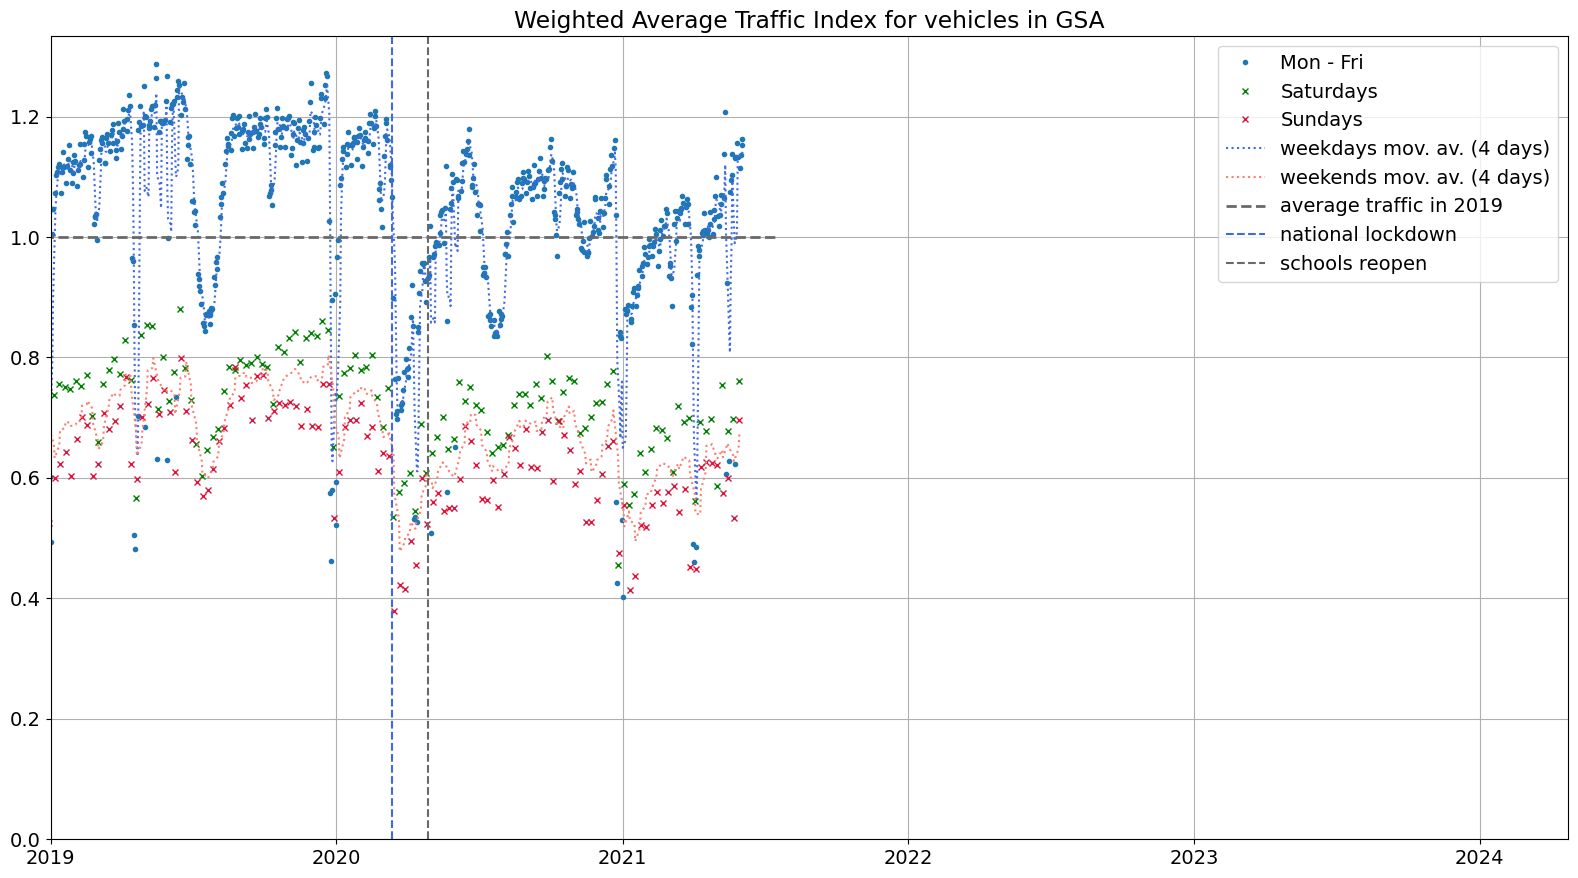

In [34]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Stavanger','Sola','Sandnes','Randaberg'])].index
GSV = process_TDD(ALL,IDs)

GSV_wavg = GSV.groupby('date').apply(wavg,'traffic_index','YADTV')
GSV_d = GSV['traffic_index'].groupby('date').describe()
GSV_d.head()


M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}, 
     '2020.04.27':{'label':'schools reopen'},
#      '2019.06.20':{'label':'Sommerruter','ls': '--','c': 'grey'},
#      '2019.08.16':{'ls': '--','c': 'grey'},
    }

plot_TI(GSV_wavg,marks = {}, title = 'Weighted Average Traffic Index for vehicles in GSA 2018-12-01 - 2020-02-01', from_date = '2018-12-01', to_date = '2020-02-01', save = True, MA = 4)
plot_TI(GSV_wavg,marks = M, title = 'Weighted Average Traffic Index for vehicles in GSA', save = True, MA = 4)

### Bicycles

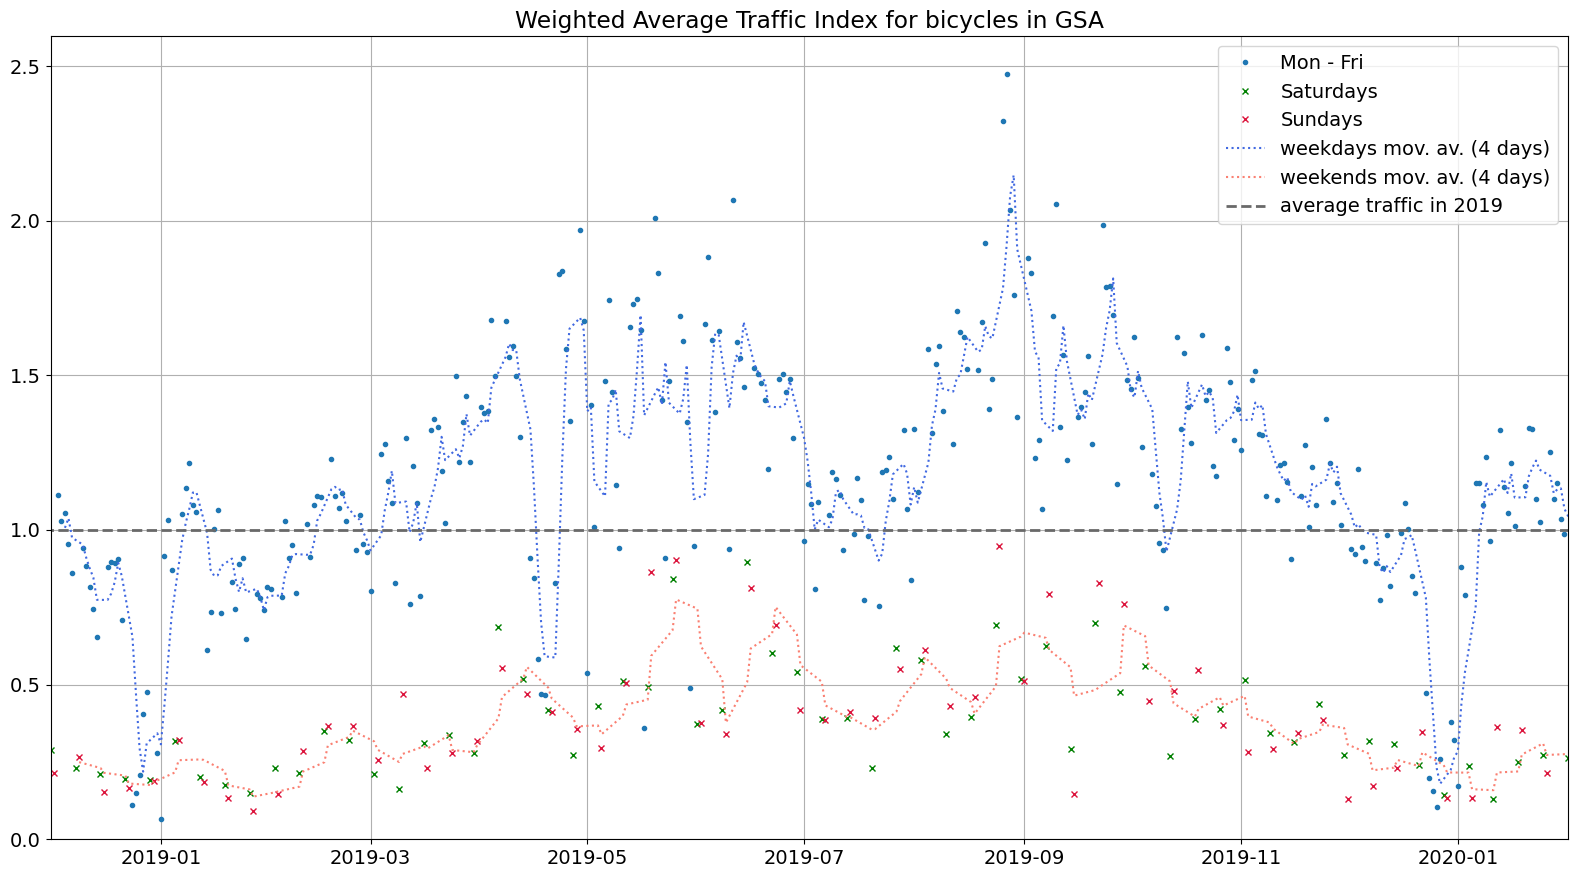

In [35]:
IDs = TRP.loc[(TRP.trafficType == 'BICYCLE') & TRP.municipality.isin(['Stavanger','Sola','Sandnes','Randaberg'])].index
GSB = process_TDD(ALL, IDs)

GSB_wavg = GSB.groupby('date').apply(wavg,'traffic_index','YADTV')
GSB_d = GSB['traffic_index'].groupby('date').describe()

plot_TI(GSB_wavg, title = 'Weighted Average Traffic Index for bicycles in GSA', from_date = '2018-12-01', to_date = '2020-02-01',  save = True, MA = 4)

## Comparison of Oslo, Bergen and Stavanger

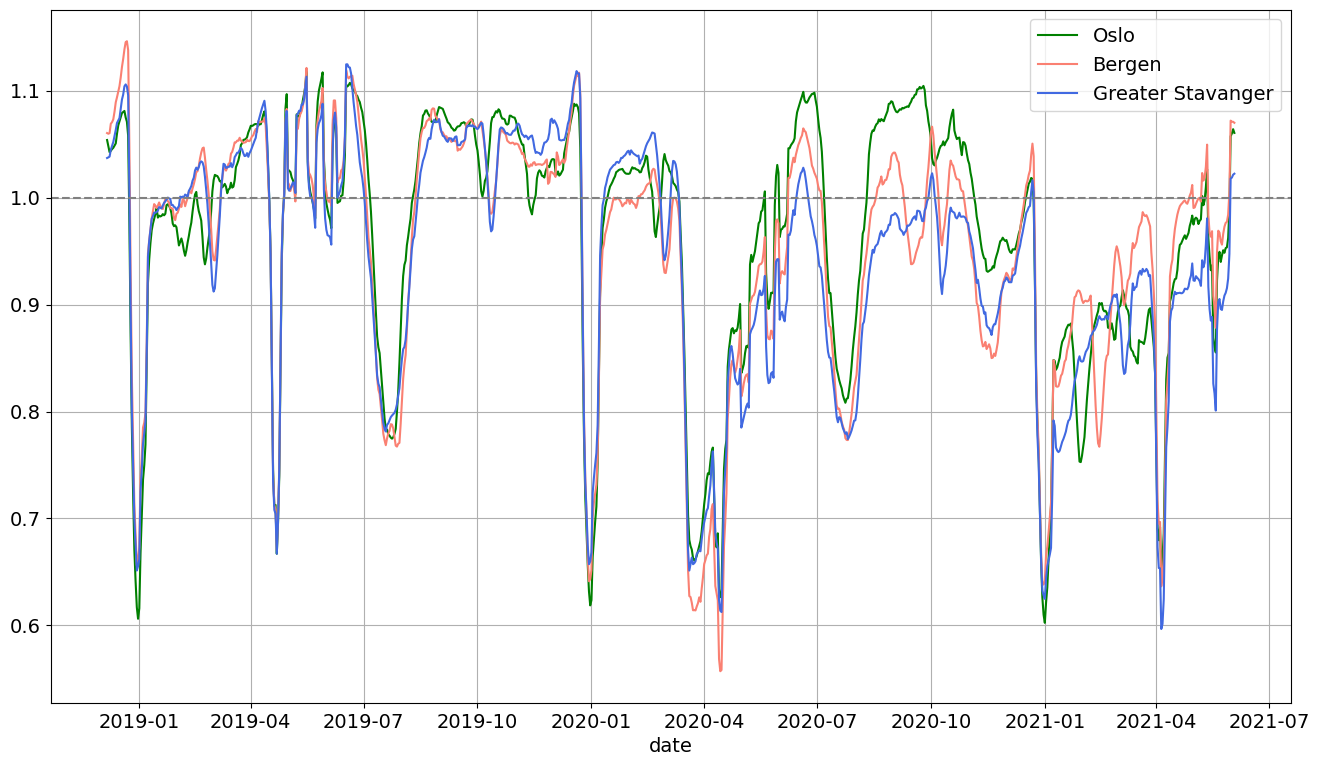

In [36]:
OSL_wavg.rolling(window = 7).mean().plot(figsize = (16,9), grid = True, label = 'Oslo', color = 'green', legend = True)
BRG_wavg.rolling(window = 7).mean().plot(figsize = (16,9), grid = True, label = 'Bergen', color = 'salmon', legend = True)
GSV_wavg.rolling(window = 7).mean().plot(figsize = (16,9), grid = True, label = 'Greater Stavanger', color = 'royalblue', legend = True)
xl = plt.xlim()
plt.plot(xl, [1, 1],'--', color = 'gray')
plt.xlim(xl)
plt.savefig('.\\figures\\Comparison of Oslo, Bergen and Stavanger.png',dpi=300)
plt.show()

## Norway

### Vehicles

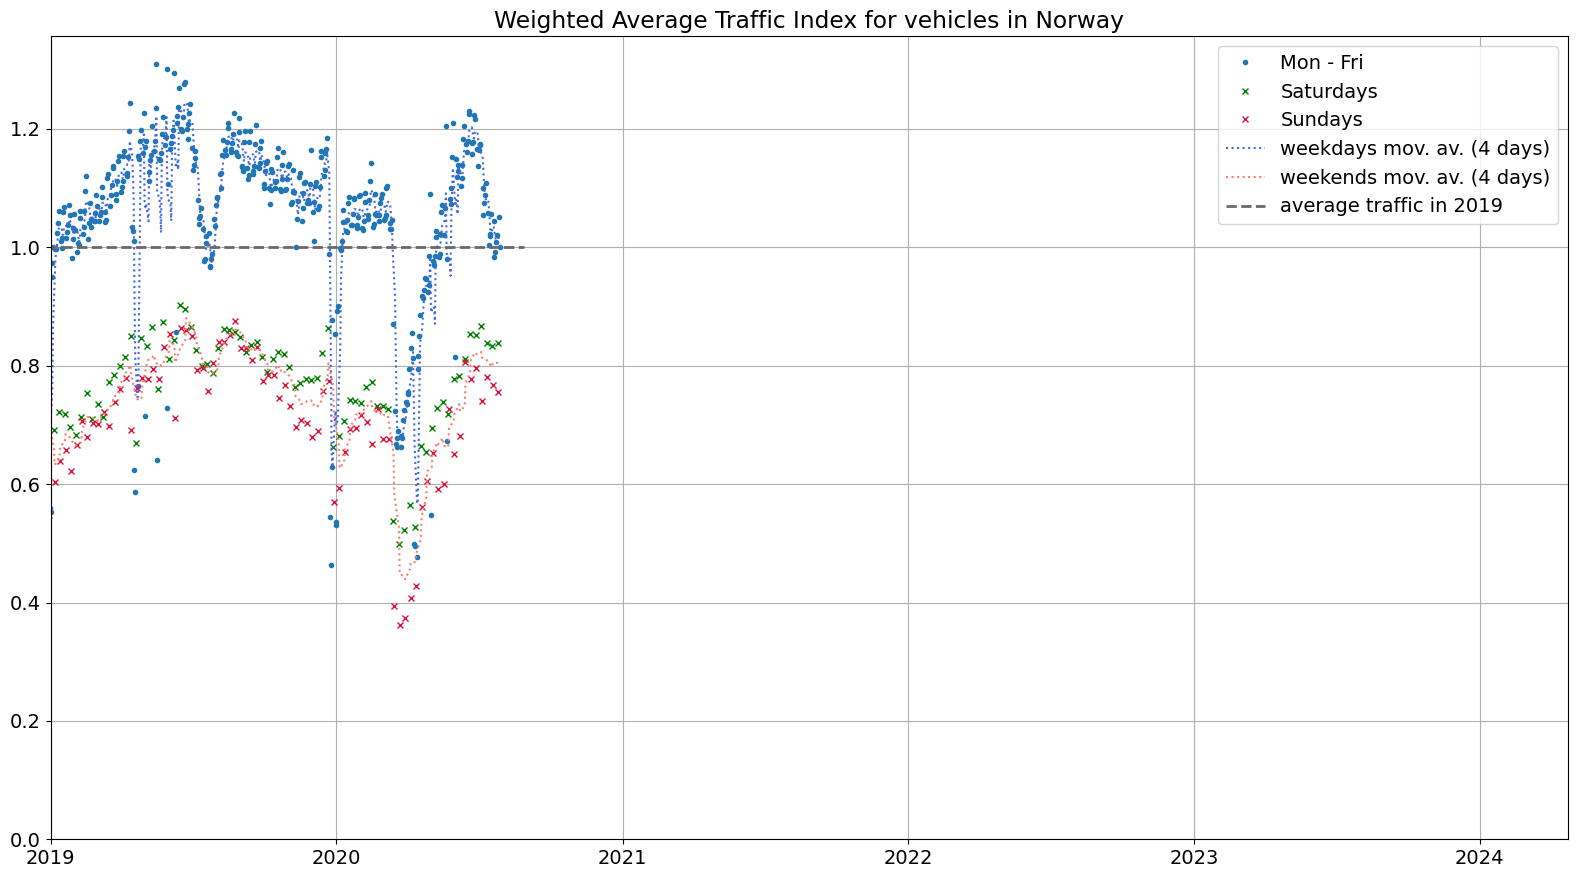

In [37]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE')].index
# read anew
fn = 'norway_vehicles.pkl'
# os.remove(fn) # uncomment this line to process the data anew
if not os.path.exists(fn):
    NV = process_TDD(ALL,IDs)
    NV_wavg = NV.groupby('date').apply(wavg,'traffic_index','YADTV')
    # saving:
    with open(fn, 'wb') as f:
        pickle.dump([NV, NV_wavg], f)
else:
    # loading:
    with open(fn,'rb') as f:
        NV, NV_wavg = pickle.load(f)
        
plot_TI(NV_wavg, title = 'Weighted Average Traffic Index for vehicles in Norway', save = True, MA = 4)

## Comparison of Oslo, Bergen, Stavanger and Norway

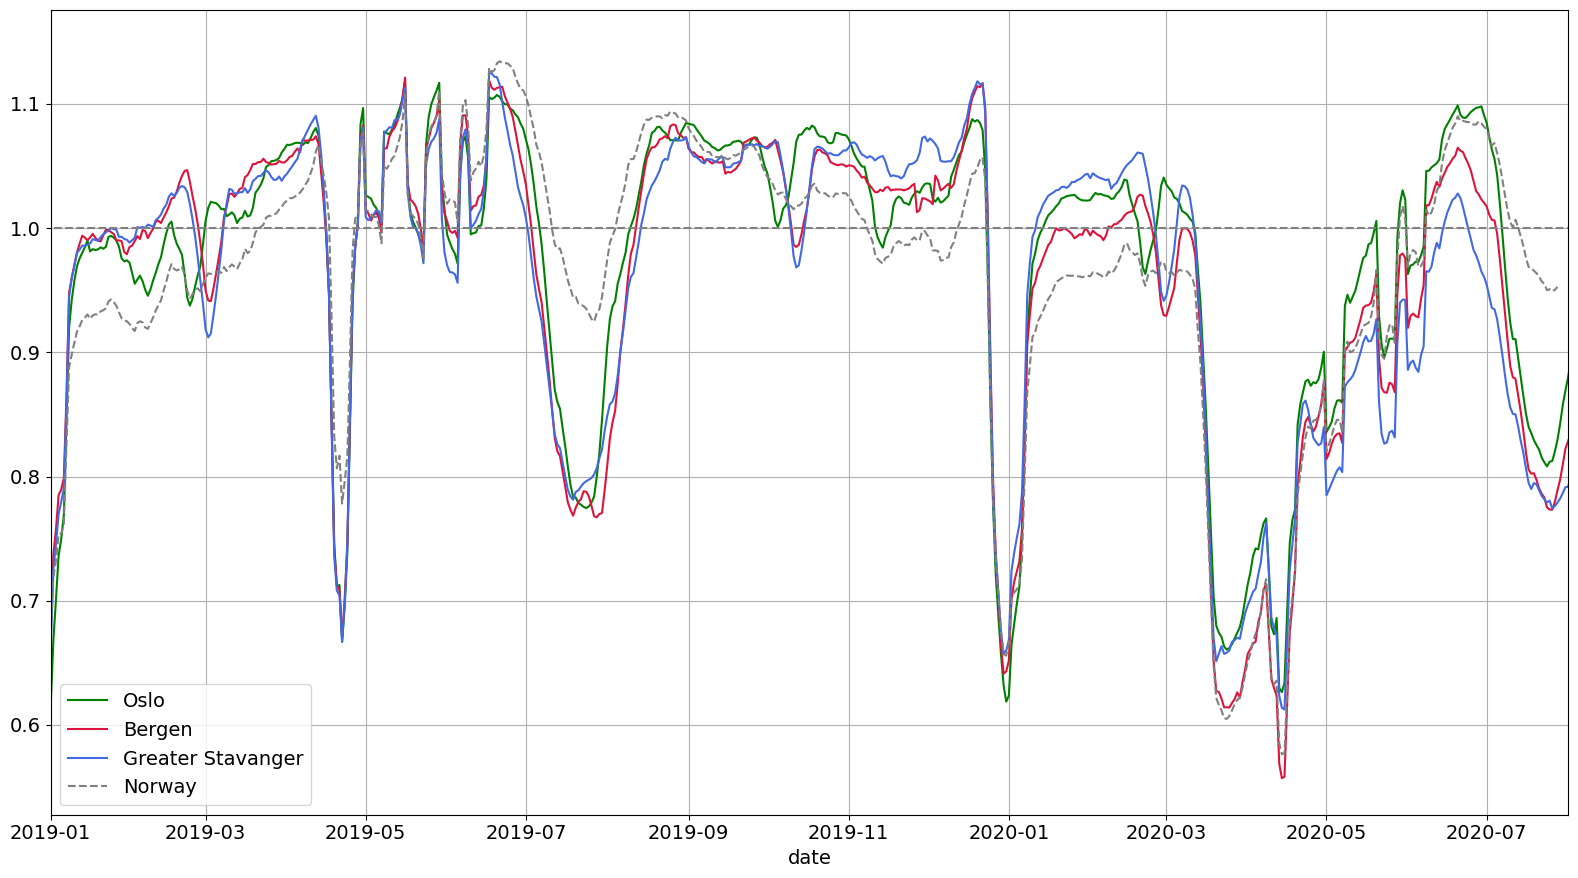

In [38]:
OSL_wavg.rolling(window = 7).mean().plot(figsize = (16,9), grid = True, label = 'Oslo', color = 'green', legend = True)
BRG_wavg.rolling(window = 7).mean().plot(figsize = (16,9), grid = True, label = 'Bergen', color = 'crimson', legend = True)
GSV_wavg.rolling(window = 7).mean().plot(figsize = (16,9), grid = True, label = 'Greater Stavanger', color = 'royalblue', legend = True)
NV_wavg.rolling(window = 7).mean().plot(figsize = (16,9), grid = True, label = 'Norway', color = 'grey', legend = True, ls = '--')
xl = plt.xlim()
plt.plot(xl, [1, 1],'--', color = 'gray')

from_date = datetime.fromisoformat('2019-01-01').date()
to_date = datetime.fromisoformat('2020-08-01').date()
    
plt.xlim(from_date,to_date)
plt.tight_layout()
plt.savefig('.\\figures\\Comparison of Oslo, Bergen, Stavanger and Norway.png',dpi=300)
plt.show()

### Bicycles

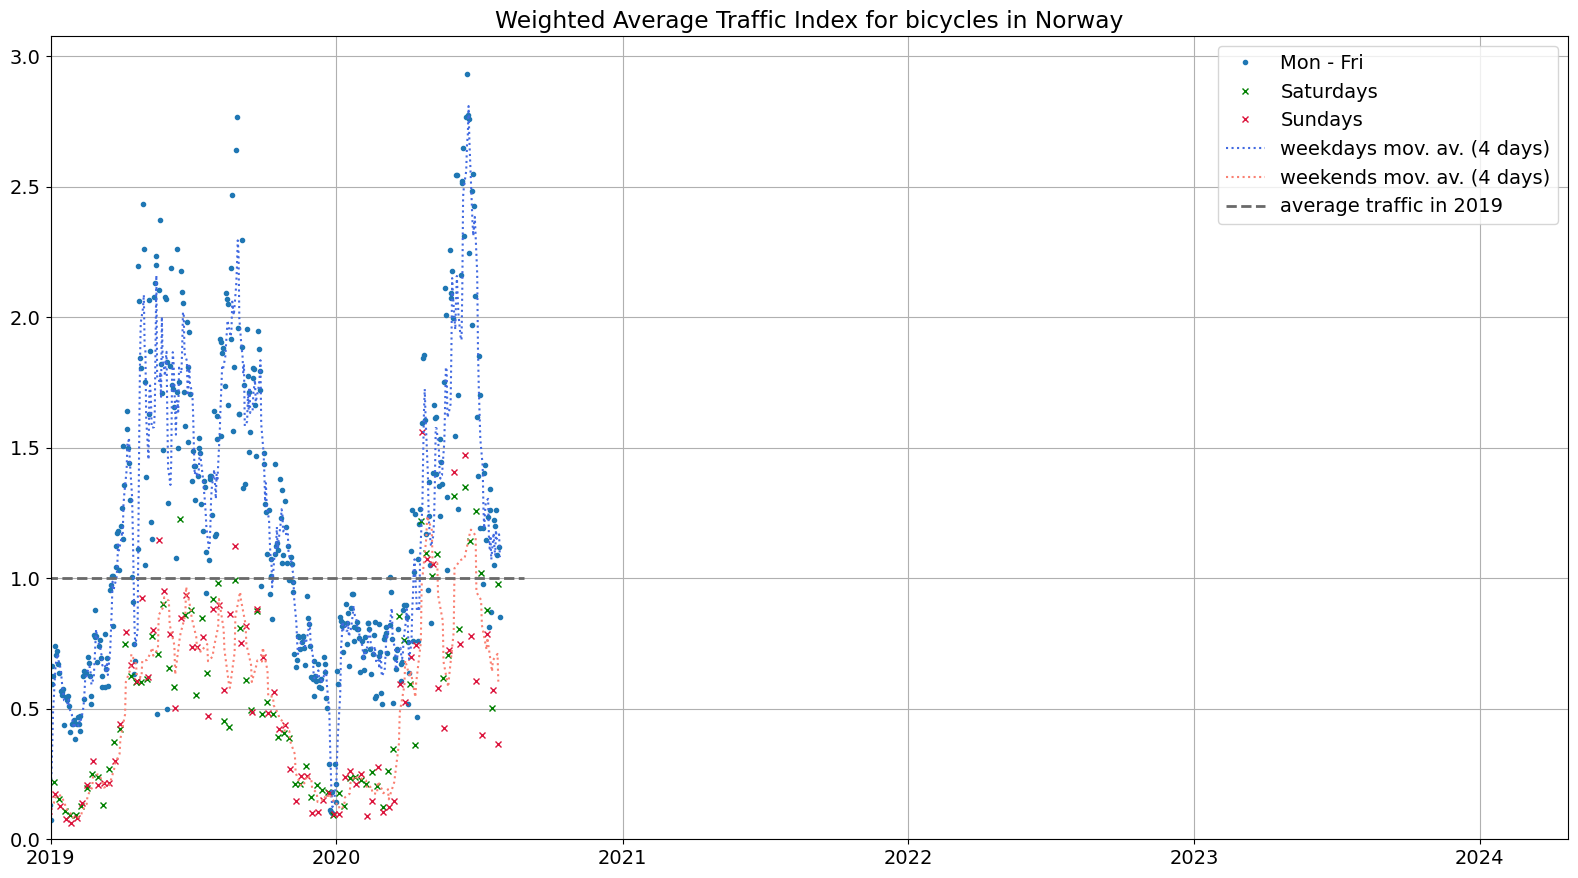

In [39]:
IDs = TRP.loc[(TRP.trafficType == 'BICYCLE')].index
# read anew
fn = 'norway_bicycles.pkl'
# os.remove(fn) # uncomment this line to process the data anew
if not os.path.exists(fn):
    NB = process_TDD(ALL,IDs)
    NB_wavg = NB.groupby('date').apply(wavg,'traffic_index','YADTV')
    # saving:
    with open(fn, 'wb') as f:
        pickle.dump([NB, NB_wavg], f)
else:
    # loading:
    with open(fn,'rb') as f:
        NB, NB_wavg = pickle.load(f)
        
plot_TI(NB_wavg, title = 'Weighted Average Traffic Index for bicycles in Norway', save = True, MA = 4)

## Airports

### Harstad/Narvik Airport (Evenes flyplass)

C:\Users\alkh\AppData\Local\Temp\ipykernel_23240\2554925559.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date([d,  d], ylim, color = marks[k]['c'], linestyle = marks[k]['ls'], label = marks[k].get('label'), marker = None)


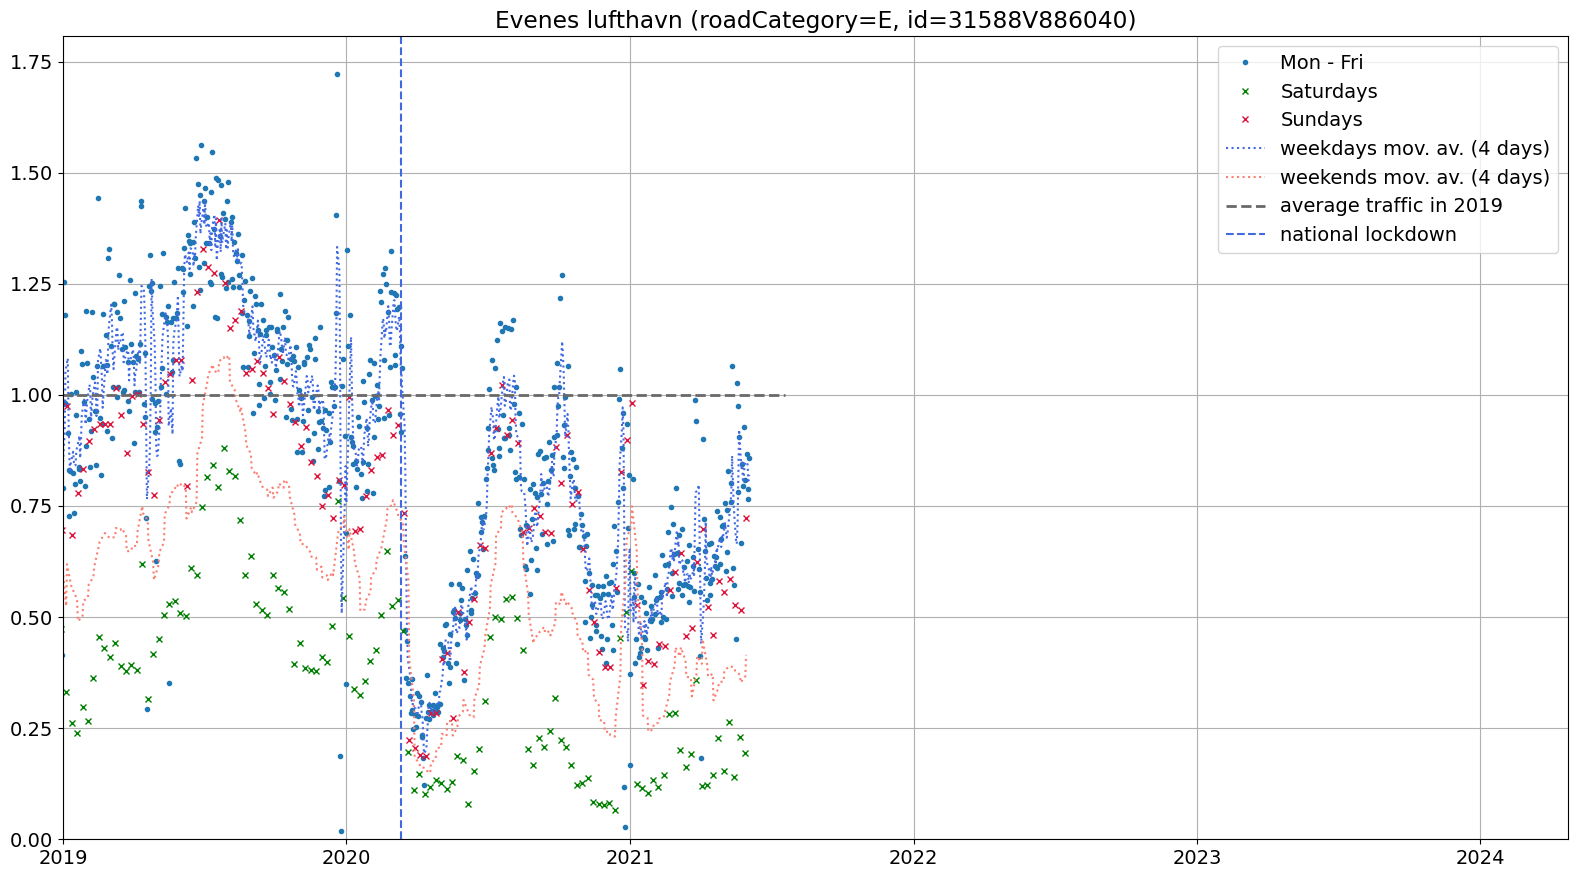

In [40]:
id = '31588V886040' # Evenes flyplass (Harstad/Narvik Airport)
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}
plot_TI(ALL[id], id, from_date = '2019-01-01', to_date = time_now_str, marks = M, save = True, MA = 4)

### Bergen, Flesland

C:\Users\alkh\AppData\Local\Temp\ipykernel_23240\2554925559.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date([d,  d], ylim, color = marks[k]['c'], linestyle = marks[k]['ls'], label = marks[k].get('label'), marker = None)


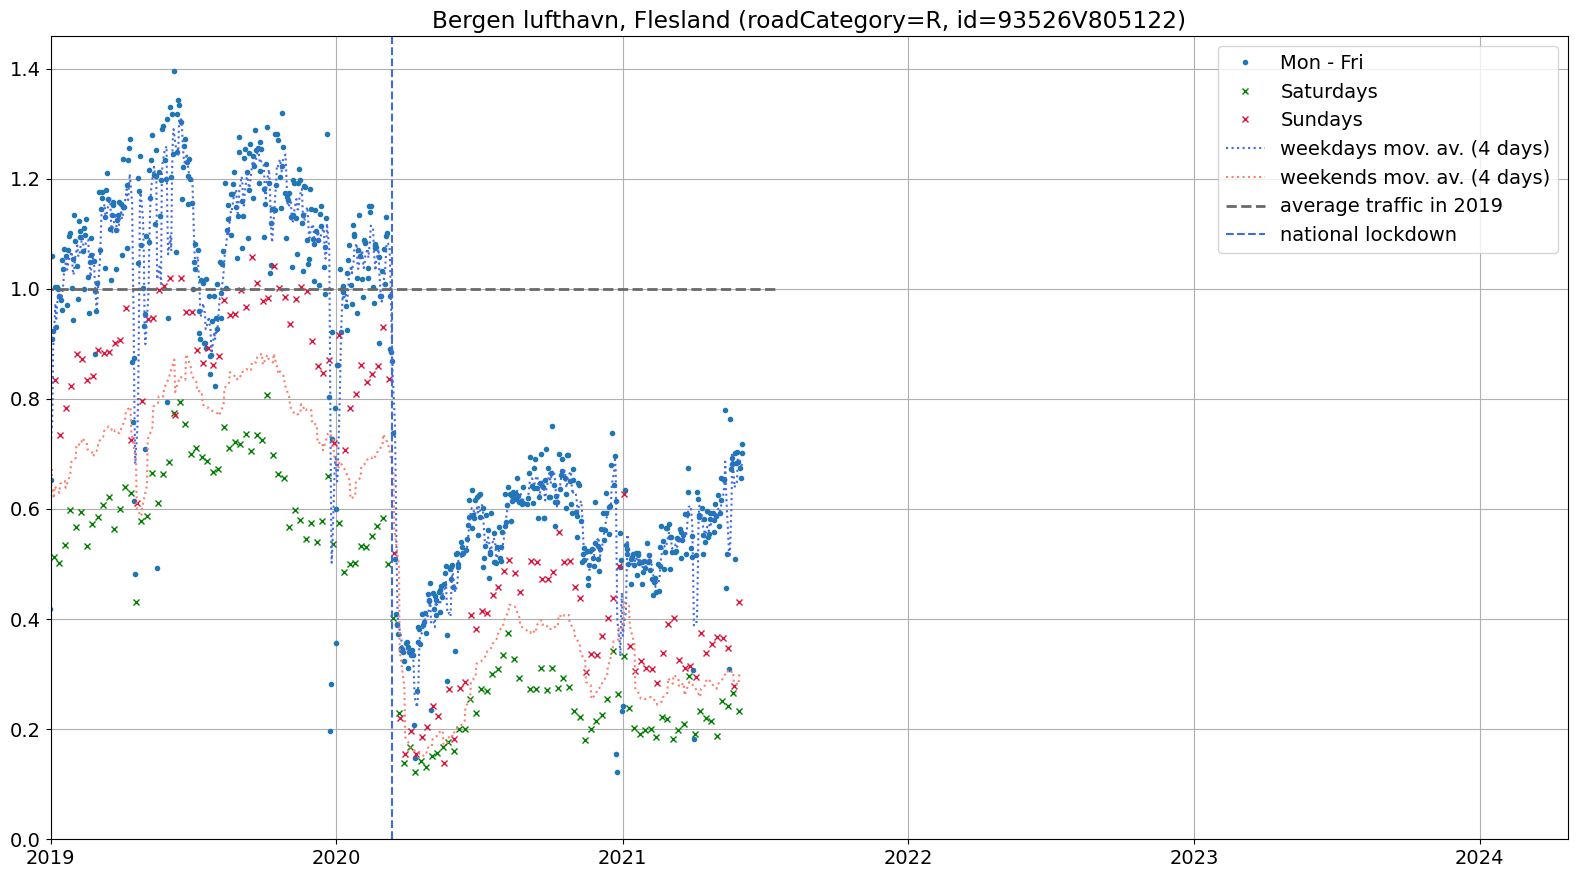

In [41]:
id = '93526V805122' # BG.LUFTHAVN,FLESLAND
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}
plot_TI(ALL[id], id, from_date = '2019-01-01', to_date = time_now_str, marks = M, save = True, MA = 4)

C:\Users\alkh\AppData\Local\Temp\ipykernel_23240\2554925559.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date([d,  d], ylim, color = marks[k]['c'], linestyle = marks[k]['ls'], label = marks[k].get('label'), marker = None)


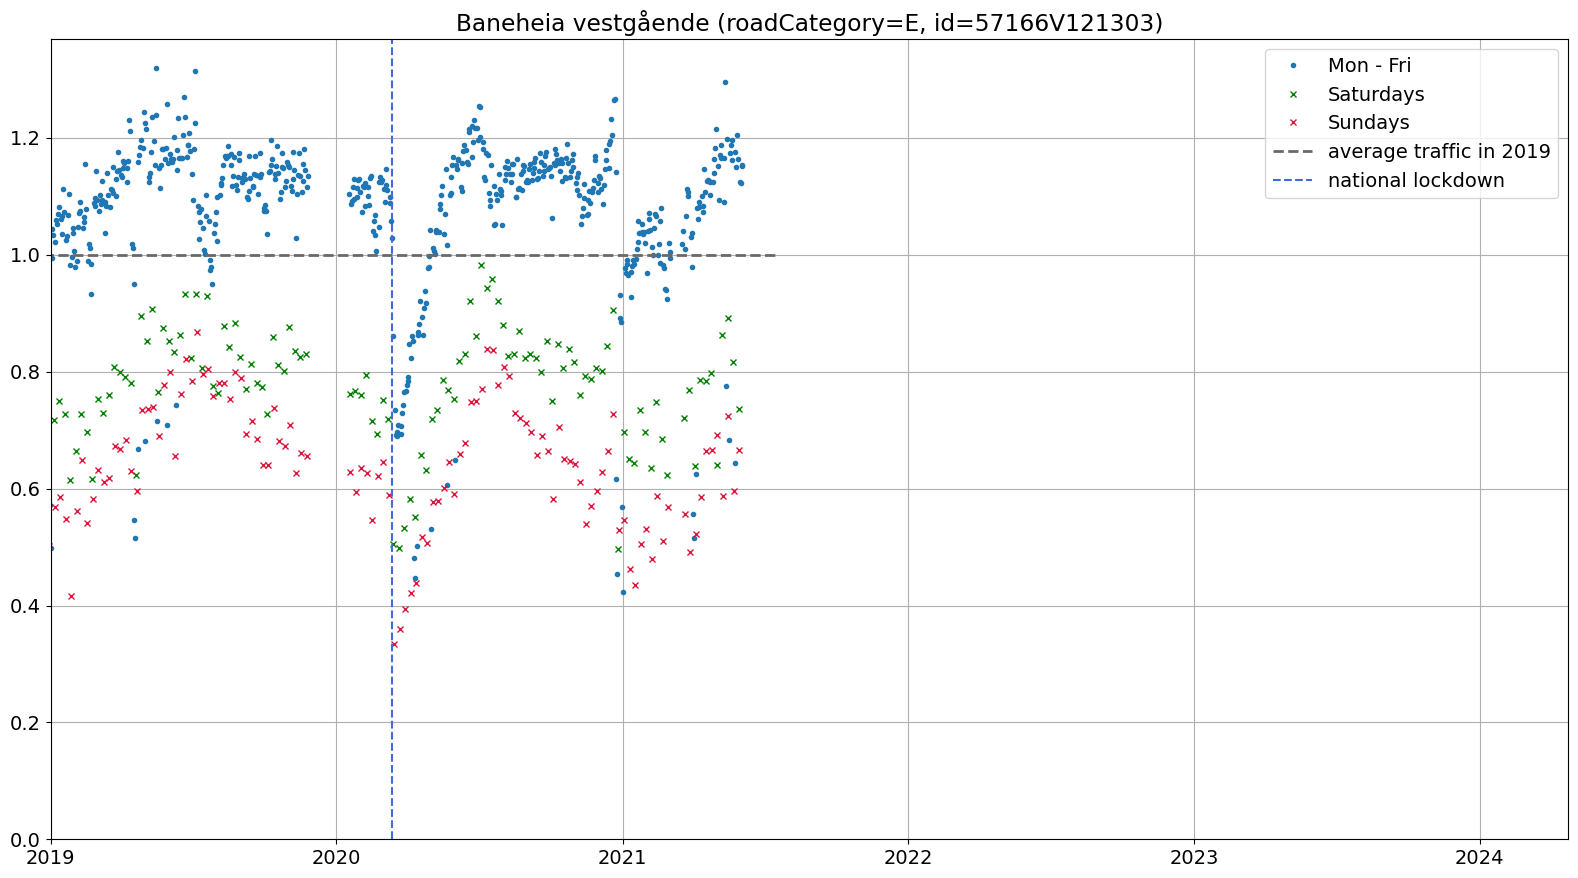

In [42]:
id = '57166V121303' # BANEHEIA VESTGÅENDE

M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}, 
    }

plot_TI(ALL[id], id, from_date = '2019-01-01', to_date = time_now_str, marks = M, save = True)

## Skiing areas

### Hol (Geilo)

C:\Users\alkh\AppData\Local\Temp\ipykernel_23240\2554925559.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date([d,  d], ylim, color = marks[k]['c'], linestyle = marks[k]['ls'], label = marks[k].get('label'), marker = None)


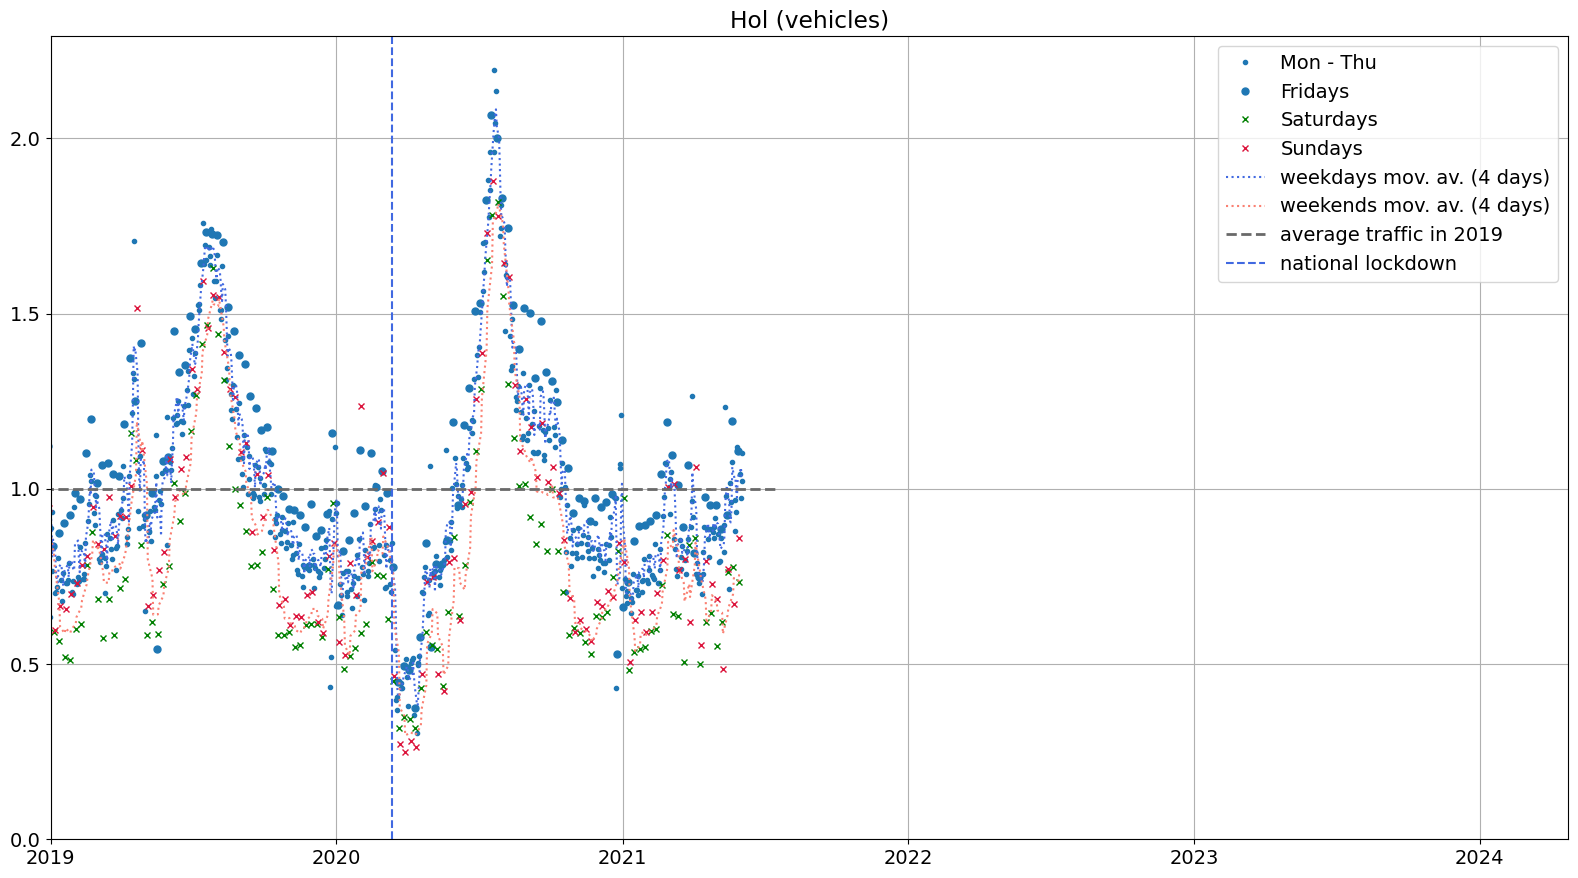

In [43]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Hol'])].index
Hol = process_TDD(ALL,IDs)
Hol_wavg = Hol.groupby('date').apply(wavg,'traffic_index','YADTV')
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}
plot_TI(Hol_wavg, title = 'Hol (vehicles)', marks = M, save = True, MA = 4, fridays = True)

### Sirdal

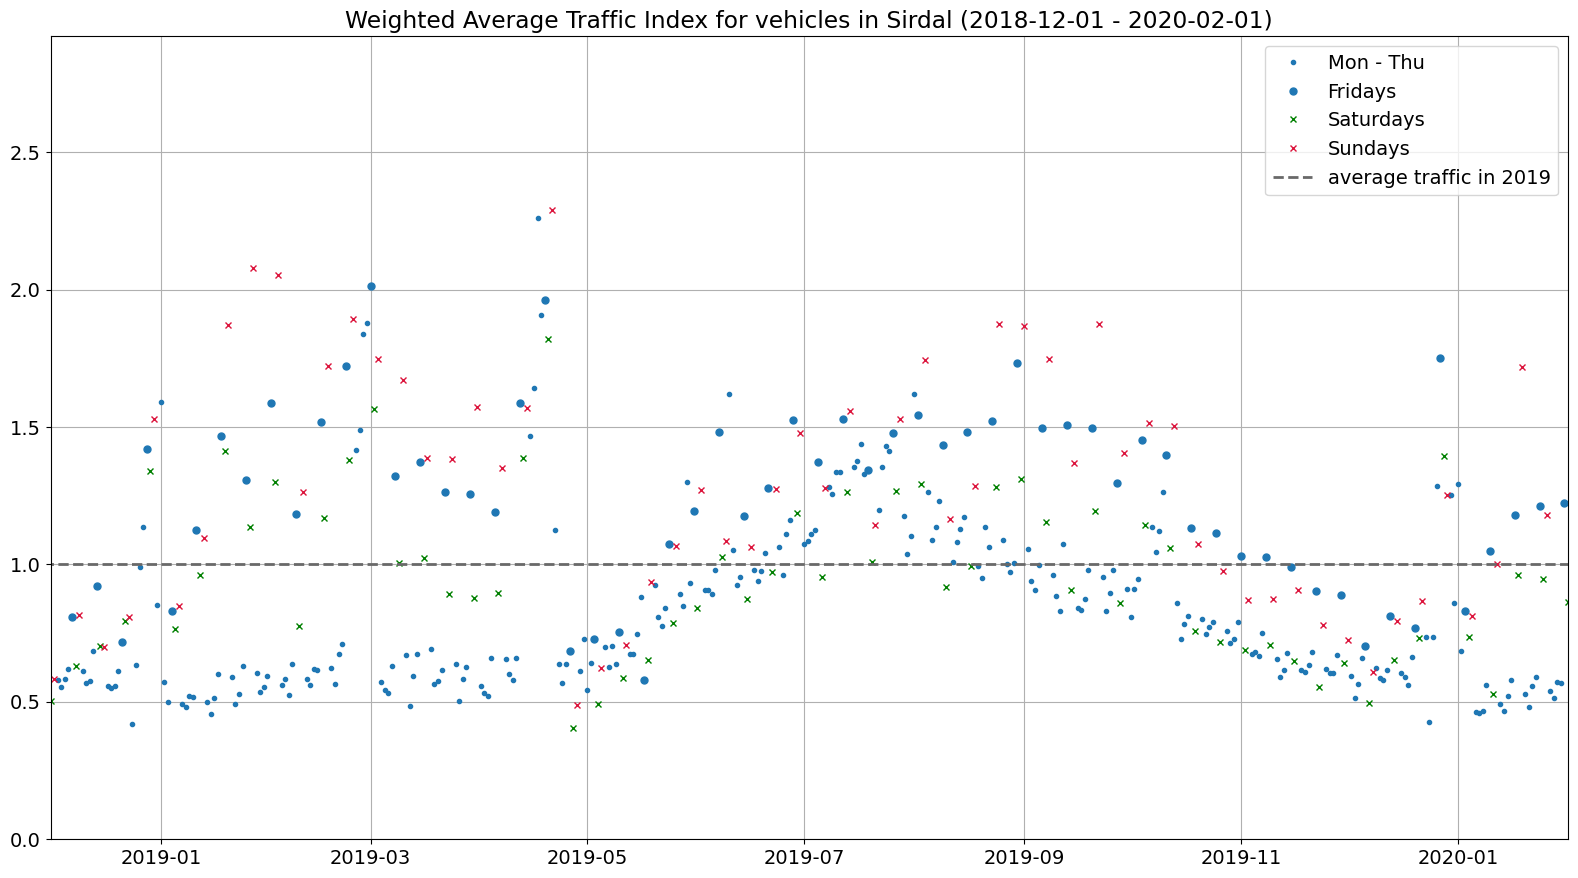

In [44]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Sirdal'])].index
Sirdal = process_TDD(ALL,IDs)
Sirdal_wavg = Sirdal.groupby('date').apply(wavg,'traffic_index','YADTV')
# plot_TI(Sirdal_wavg,marks = M, title = 'Weighted Average Traffic Index for vehicles in GSA 2018-12-01 - 2020-02-01', from_date = '2018-12-01', to_date = '2020-02-01', save = True, MA = 4)
plot_TI(Sirdal_wavg, title = 'Weighted Average Traffic Index for vehicles in Sirdal (2018-12-01 - 2020-02-01)', from_date = '2018-12-01', to_date = '2020-02-01', save = True, fridays = True)

C:\Users\alkh\AppData\Local\Temp\ipykernel_23240\2554925559.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date([d,  d], ylim, color = marks[k]['c'], linestyle = marks[k]['ls'], label = marks[k].get('label'), marker = None)


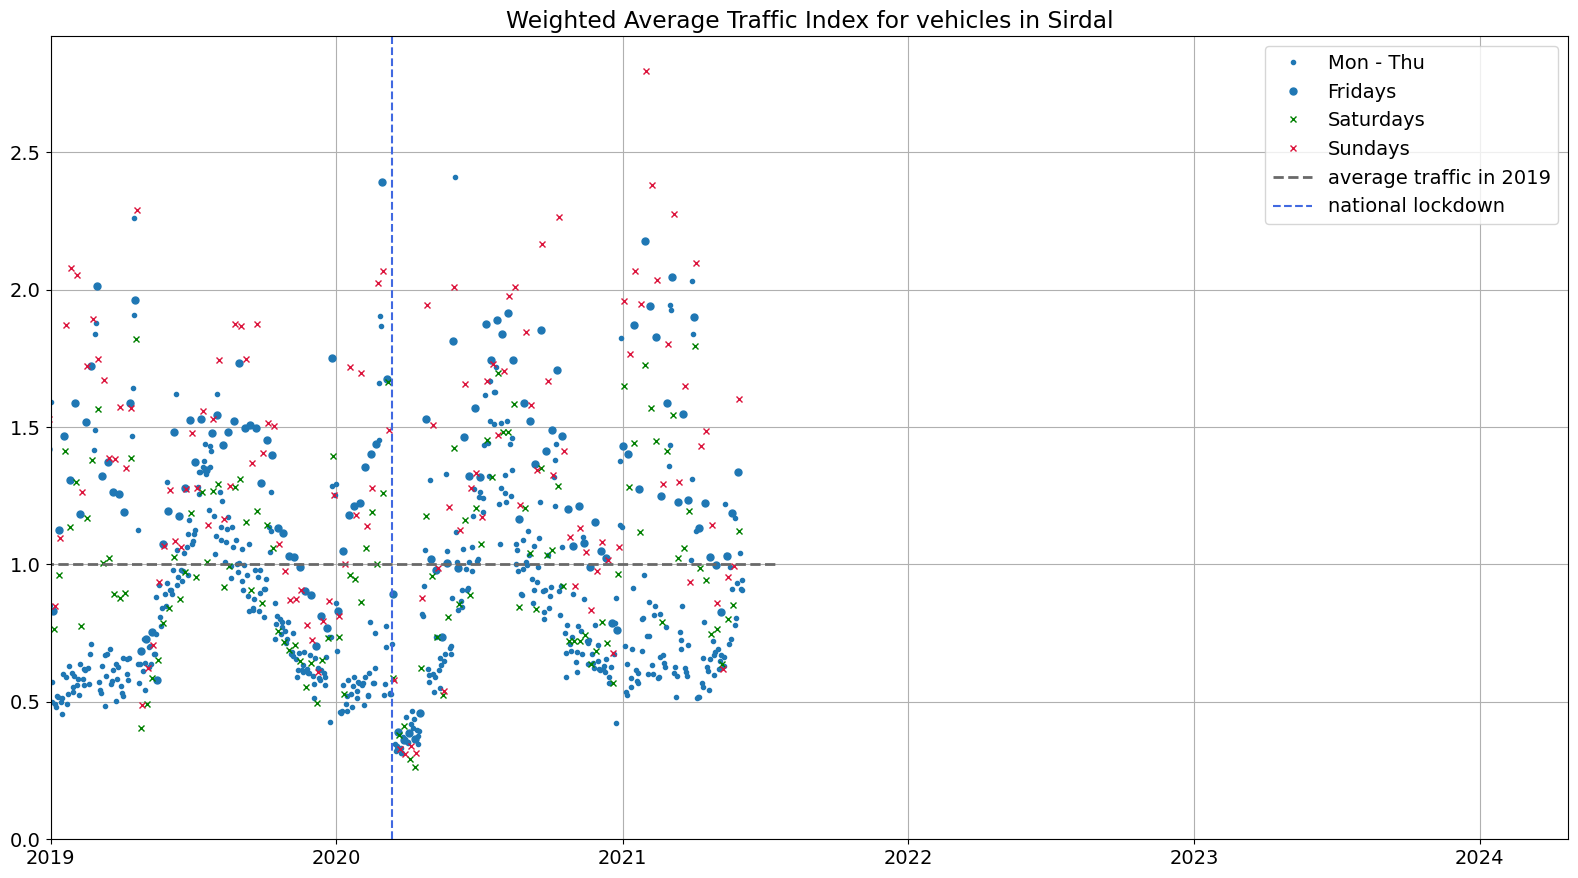

In [45]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Sirdal'])].index
Sirdal = process_TDD(ALL,IDs)
Sirdal_wavg = Sirdal.groupby('date').apply(wavg,'traffic_index','YADTV')
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}

# plot_TI(Sirdal_wavg,marks = M, title = 'Weighted Average Traffic Index for vehicles in GSA 2018-12-01 - 2020-02-01', from_date = '2018-12-01', to_date = '2020-02-01', save = True, MA = 4)
plot_TI(Sirdal_wavg, title = 'Weighted Average Traffic Index for vehicles in Sirdal', marks = M, save = True, fridays = True)

### Trysil

C:\Users\alkh\AppData\Local\Temp\ipykernel_23240\2554925559.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date([d,  d], ylim, color = marks[k]['c'], linestyle = marks[k]['ls'], label = marks[k].get('label'), marker = None)


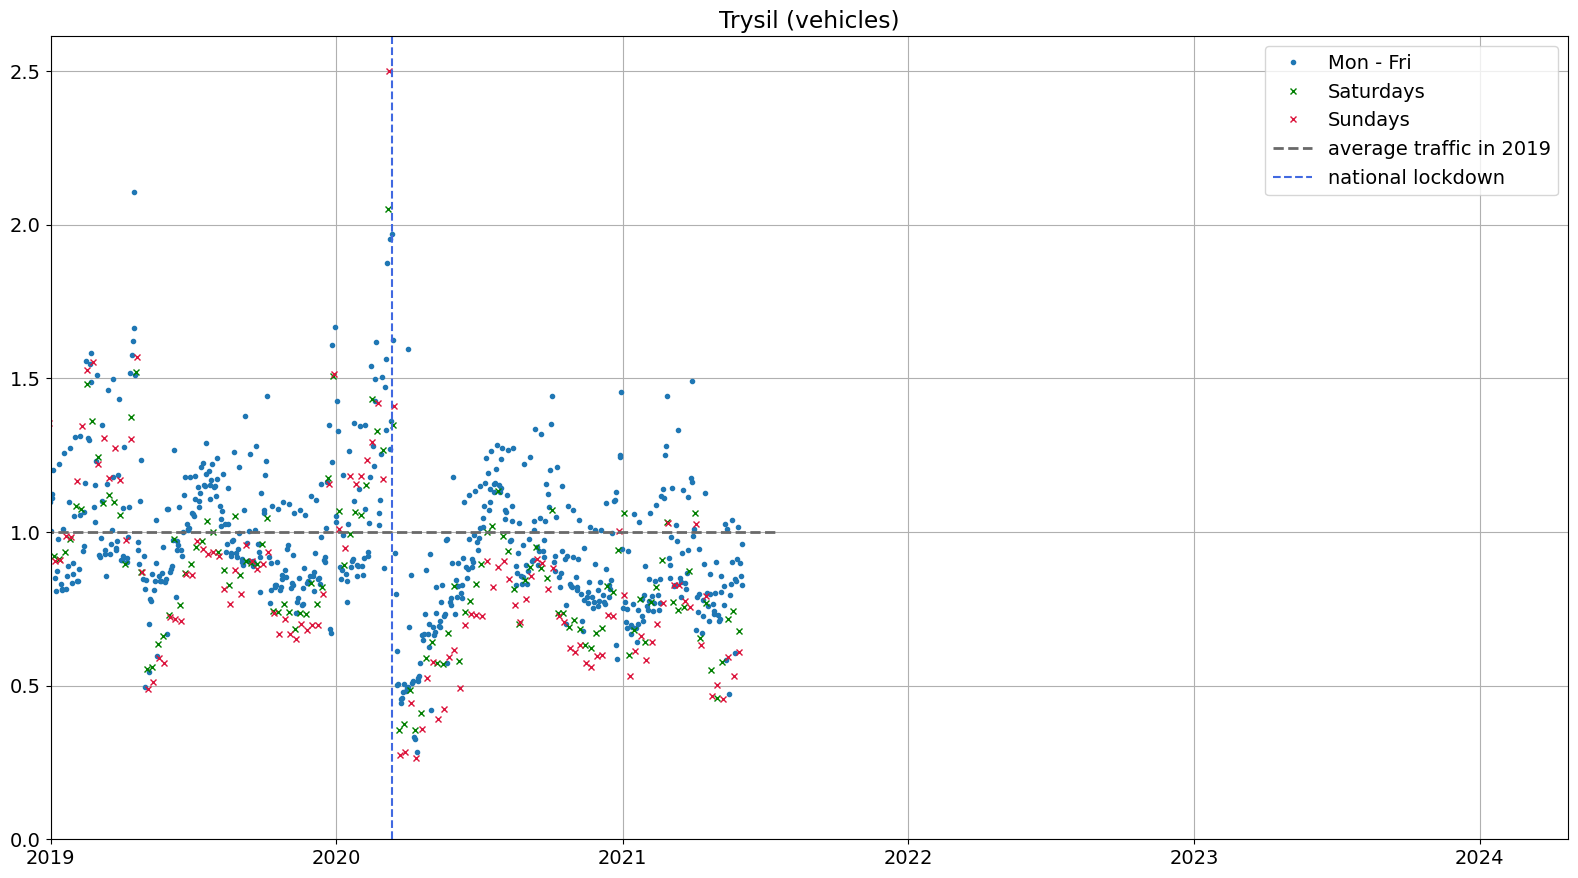

In [46]:
IDs = TRP.loc[(TRP.trafficType == 'VEHICLE') & TRP.municipality.isin(['Trysil'])].index
Trysil = process_TDD(ALL,IDs)
Trysil_wavg = Trysil.groupby('date').apply(wavg,'traffic_index','YADTV')
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}
plot_TI(Trysil_wavg, title = 'Trysil (vehicles)', marks = M, save = True)

## Boarders

### Sweden (Svinesund bridge)

C:\Users\alkh\AppData\Local\Temp\ipykernel_23240\2554925559.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date([d,  d], ylim, color = marks[k]['c'], linestyle = marks[k]['ls'], label = marks[k].get('label'), marker = None)


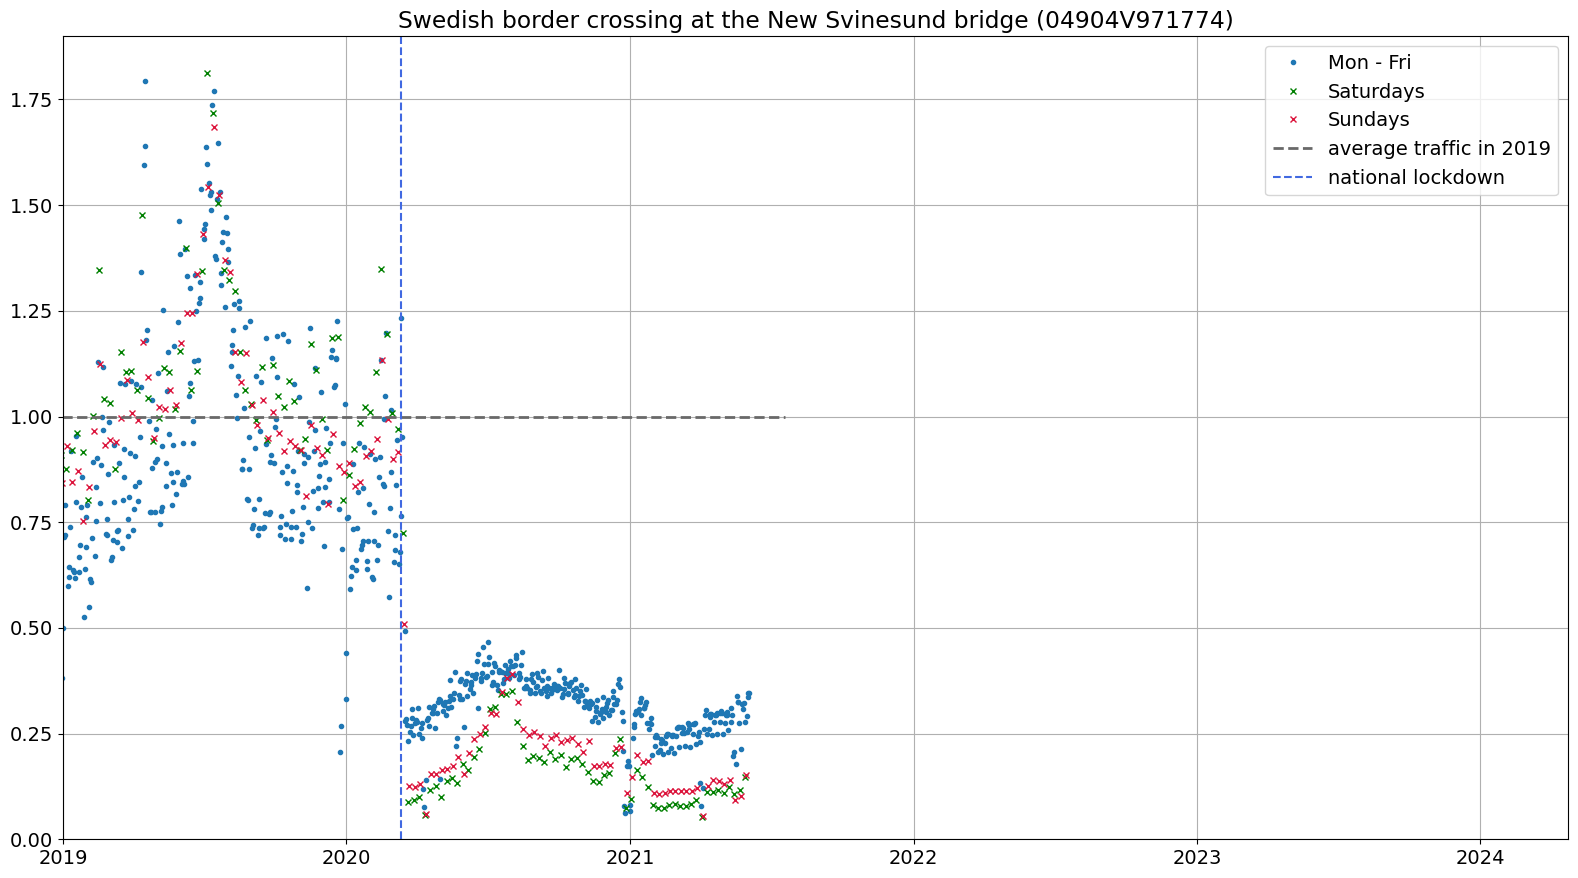

In [47]:
id = '04904V971774'  # NYE SVINESUND BRU, trafficType = VEHICLE, municipality = Halden
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}
plot_TI(ALL[id], id, title = 'Swedish border crossing at the New Svinesund bridge ('+id+')' , marks = M, save = True)

### Russia (Storskog)
Storskog is a border crossing station on the Norwegian side of the Norway-Russia border, along the European route E105 highway. The crossing is located in Sør-Varanger Municipality in Finnmark county on the Norway side of the border.
https://en.wikipedia.org/wiki/Storskog

C:\Users\alkh\AppData\Local\Temp\ipykernel_23240\2554925559.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date([d,  d], ylim, color = marks[k]['c'], linestyle = marks[k]['ls'], label = marks[k].get('label'), marker = None)


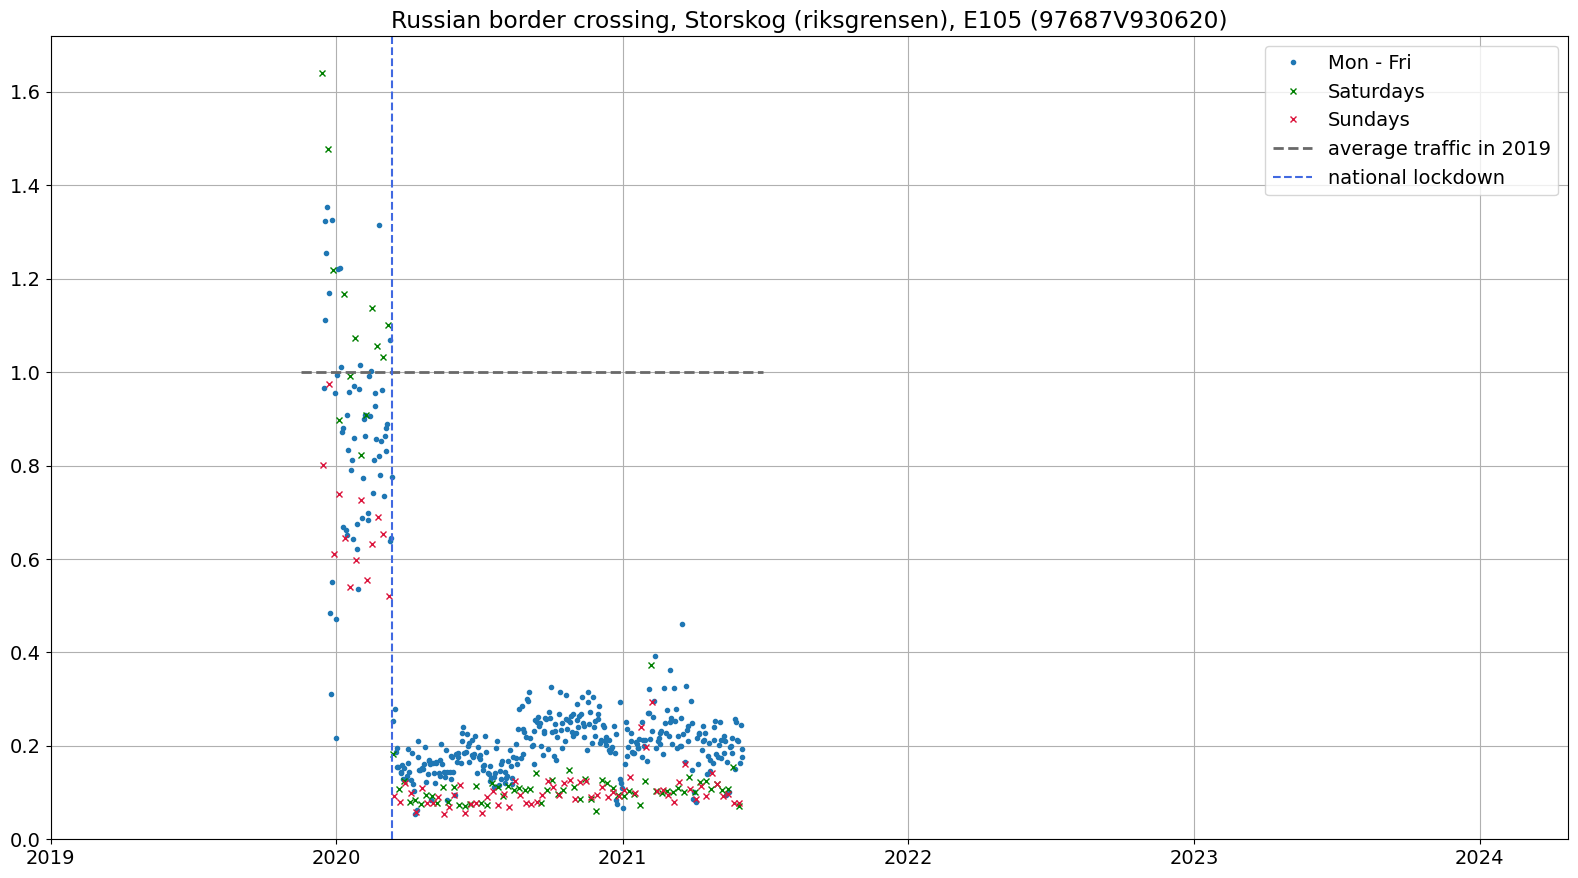

In [48]:
id = '97687V930620' # name = Storskog RGR, trafficType	VEHICLE, municipality = Sør-Varanger
# id = '61723V2435179'
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}
plot_TI(ALL[id], id, title = 'Russian border crossing, ' + TRP.name[id] +', E105 ('+ id +')' , marks = M, save = True)

### Finnland (Aidejavri RGR)

C:\Users\alkh\AppData\Local\Temp\ipykernel_23240\2554925559.py:93: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date([d,  d], ylim, color = marks[k]['c'], linestyle = marks[k]['ls'], label = marks[k].get('label'), marker = None)


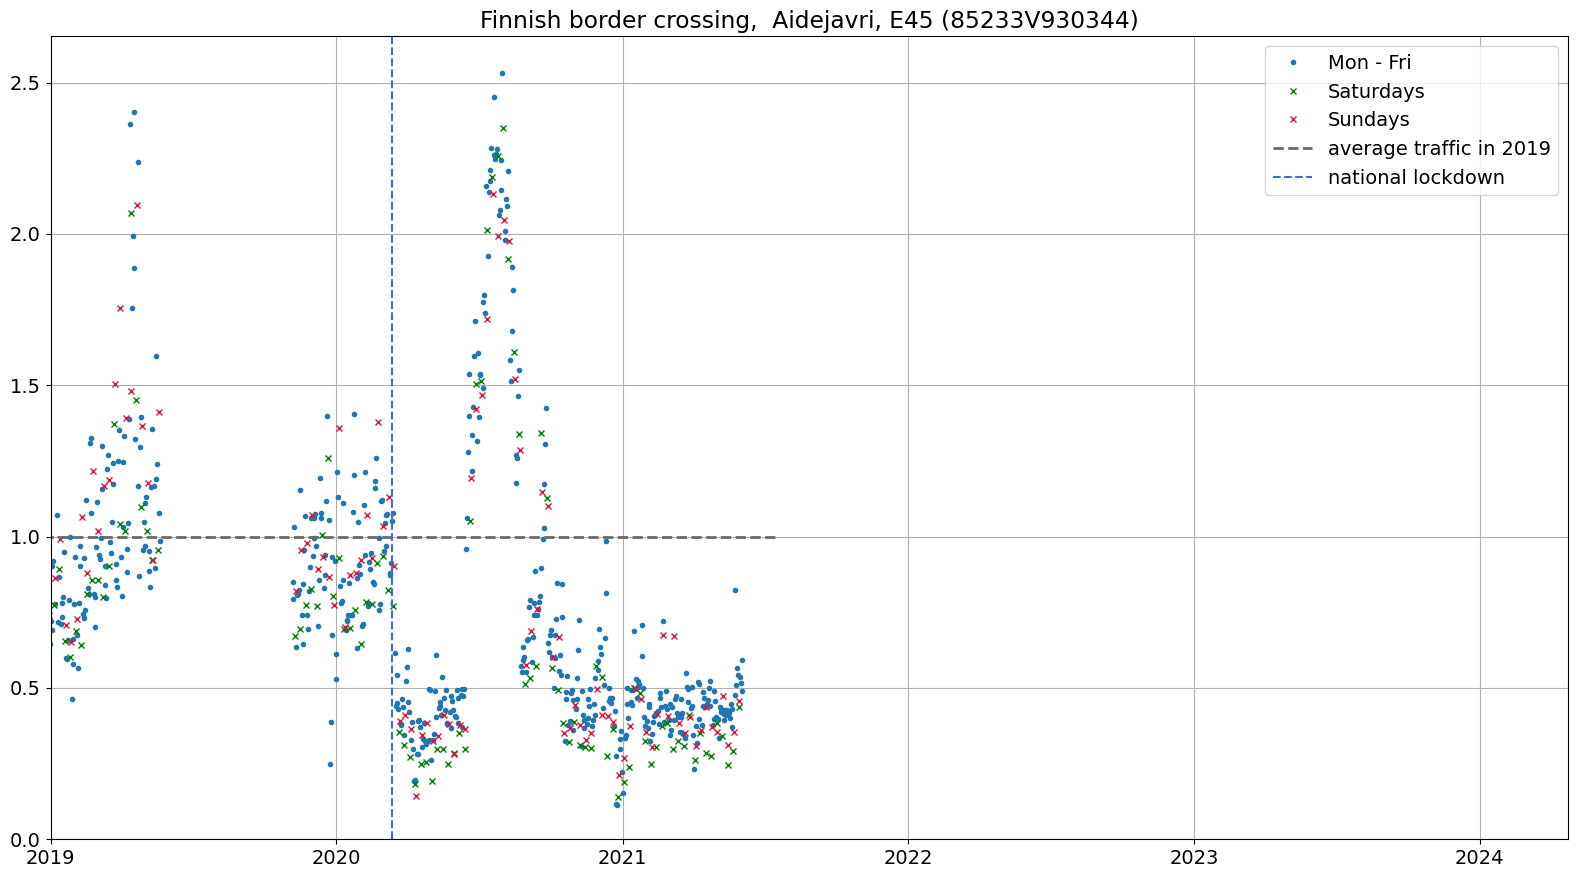

In [49]:
id = '85233V930344'  # Aidejavri RGR (E45), trafficType = VEHICLE, municipality	Kautokeino
M = {'2020.03.12': {'label': 'national lockdown','c': 'royalblue','ls': '--'}}
plot_TI(ALL[id], id, title = 'Finnish border crossing,  ' + TRP.name[id] +', E45 ('+ id +')' , marks = M, save = True)

## Preparing input for Kepler.GL to visualise year-over-year traffic ratio

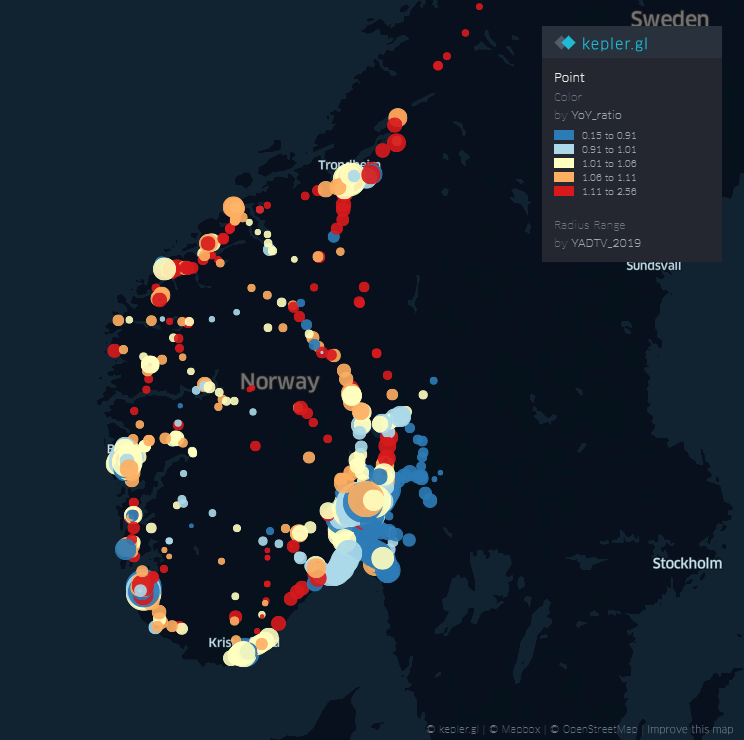

The code below:
- copies TRP to TRP_YoY
- adds the column YoY_ratio: [YoY_ratio] = [MA of Traffic Index @ t2]/[MA of Traffic Index @ t1]
- adds column with Yearly Averaged Daily Traffic Volume in 2019 YoY_ratio
- saves the result TRP_YoY.csv 

An example map is saved in 'YoY_traffic_comparison.json'

In [50]:
t1 = '2019-07-27' # 
t2 = '2020-07-27' #
tt1 = datetime.fromisoformat(t1).date()
tt2 = datetime.fromisoformat(t2).date()

TRP_YoY = TRP.copy()
for i,id in enumerate(ALL.keys()):
    try:
        TRP_YoY.loc[id,'YADTV_2019'] = ALL[id]['YADTV'][tt2]        
        YoY_ratio = ALL[id]['traffic_index_MA7'][tt2]/ALL[id]['traffic_index_MA7'][tt1]
        TRP_YoY.loc[id,'YoY_ratio'] = YoY_ratio
        l = 'ok'
    except:
        l = 'some error'
    print(i,id,l)        
    if (i + 1) % 25 == 0:
        clear_output()
        
TRP_YoY.replace([np.inf, -np.inf], np.nan, inplace=True)
TRP_YoY.dropna(inplace=True)
TRP_YoY['YoY_ratio'] = TRP_YoY['YoY_ratio'].round(2)
# TRP_YoY.drop(columns = ['r'], inplace = True)
TRP_YoY = TRP_YoY.loc[(TRP_YoY['YoY_ratio']>0.01) & (TRP_YoY['YoY_ratio']<2.5),:]

TRP_YoY['YoY_bins'] = None

TRP_YoY['YoY_bins']  = pd.cut(TRP_YoY['YoY_ratio'], [-np.inf, 0.75, 0.9, 1.1, 1.25, np.inf],
                                   labels = ['1) <-25%', '2) -25%...+10%', '3) -10%...+10%', '4) +10%...+25%', '5) >+25%'])
TRP_YoY.to_csv('TRP_YoY.csv')
# TRP_YoY['YoY_ratio'].describe()
TRP_YoY

2475

 99115V249438 ok
2476 06966B971804 ok
2477 01749V885956 some error
2478 83708V384493 ok
2479 05666V971546 ok
2480 29852V2460300 ok
2481 25926V2725990 some error
2482 37724V1707378 ok
2483 45892V886032 ok
2484 77240V121772 ok
2485 94231V705137 ok
2486 93341V248912 ok
2487 64040V320581 ok
2488 71241V2460301 ok
2489 55622V384514 ok
2490 22576V805808 ok
2491 31429V2791530 ok


name trafficType municipality  \
id                                                                           
52742V2282262                          ØRBEKK EV6     VEHICLE     Eidsvoll   
01050V1126115                           Trollvika     VEHICLE        Senja   
24748V22148                              Pinesund     VEHICLE     Gjerstad   
11446V1175840                           Melsomvik     VEHICLE   Sandefjord   
78755V249572                                Sogge     VEHICLE        Rauma   
...                                           ...         ...          ...   
88584V704881                           SANDVIKA N     VEHICLE       Stange   
93600V72317                          Hove camping     VEHICLE        Skaun   
65823V1668921                    Fjøsdalen tunnel     VEHICLE     Flakstad   
88559V1685348                    Palmafossen aust     VEHICLE         Voss   
63247V3131641  Sømmevågen AVKJ MOT Sola rampe sør     VEHICLE         Sola   

                        county roadCategory                   road_ref  \
id                                                                       
52742V2282262         Akershus            E            EV6 S26D1 m1470   
01050V1126115            Troms            F            FV7874 S1D1 m97   
24748V22148              Agder            E           EV18 S20D1 m7352   
11446V1175840         Vestfold            F            FV303 S6D1 m469   
78755V249572   Møre og Romsdal            F           FV63 S14D1 m1381   
...                        ...          ...                        ...   
88584V704881         Innlandet            F          FV1852 S1D1 m3949   
93600V72317          Trøndelag            F           FV708 S2D1 m2204   
65823V1668921         Nordland            E           EV10 S2D1 m10108   
88559V1685348         Vestland            R           RV13 S35D1 m6872   
63247V3131641         Rogaland            R  RV509 S1D1 m3668 KD3 m100   

                     lat        lon  YADTV_2019  YoY_ratio        YoY_bins  
id                                                                          
52742V2282262  60.414260  11.241171     12691.0       1.16  4) +10%...+25%  
01050V1126115  69.239206  17.981692      2644.0       1.07  3) -10%...+10%  
24748V22148    58.798454   9.054728      7163.0       2.09        5) >+25%  
11446V1175840  59.229469  10.338938      6023.0       0.87  2) -25%...+10%  
78755V249572   62.526097   7.708336       711.0       1.13  4) +10%...+25%  
...                  ...        ...         ...        ...             ...  
88584V704881   60.780233  11.102001      4094.0       1.03  3) -10%...+10%  
93600V72317    63.232729  10.130506      1539.0       0.85  2) -25%...+10%  
65823V1668921  67.981670  13.175464      1125.0       1.01  3) -10%...+10%  
88559V1685348  60.635493   6.466188      6344.0       1.10  3) -10%...+10%  
63247V3131641  58.895670   5.641317      5301.0       0.91  3) -10%...+10%  

[1955 rows x 11 columns]